In [12]:
#chroma api 
#import packages
from chroma import api
api.register_key("e424a1b4a1604a3a8cc83f0792dc3253")
from chroma import Protein, Chroma
from chroma import Chroma, conditioners
from chroma.models.graph_design import GraphDesign
from chroma.models import graph_classifier, procap
import torch
import random
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import numpy as np

In [28]:
#VAE learn secondary structure
#set device and super params
#torch.cuda.set_device(1) 
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_sequence_length = 60
batch_size = 8
learning_rate = 1e-3
sequence_size = 480
num_epochs = 1000
h_dim=400
z_dim=20
sample_dir = "./new_sec/"

In [44]:
def GetCharMap(seq):
    invcharmap = []
    for s in seq:
        for c in s:
            if c not in invcharmap:
                invcharmap.append(c)
    invcharmap = sorted(invcharmap)
    charmap = {}
    count = 0
    for c in invcharmap:
        charmap[c] = count
        count += 1
    return charmap, invcharmap

def seq2oh(Seqs, charmap):
    Onehot = []
    max_length = max(len(seq) for seq in Seqs)
    for i in range(len(Seqs)):
        line = np.zeros([max_length, len(charmap)], dtype='float32')
        for j in range(len(Seqs[i])):
            line[j, charmap[Seqs[i][j]]] = 1
        Onehot.append(line)
    Onehot = np.array(Onehot)
    return Onehot

def oh2seq(oh, invcharmap):
    Seqs = []
    for i in range(oh.shape[0]):
        #seq = ''.join(invcharmap[np.argmax(oh[i, :, :], axis=1)])
        seq = ''.join([invcharmap[idx] for idx in np.argmax(oh[i, :, :], axis=1)])
        Seqs.append(seq)
    return Seqs

def saveseq(filename, seq):
    with open(filename, 'w') as f:
        for i in range(len(seq)):
            f.write(seq[i] + '\n')

def load_seq_data(filename):
    with open(filename, 'r') as f:
        seq = [line.strip() for line in f.readlines()]
    charmap, invcharmap = GetCharMap(seq)
    oh = seq2oh(seq, charmap)
    return oh, charmap, invcharmap

dataset, charmap, invcharmap = load_seq_data('protein_secondary_structure.txt')
print(charmap)
print(dataset[0])
print(dataset.shape)


{'-': 0, 'B': 1, 'E': 2, 'G': 3, 'H': 4, 'I': 5, 'S': 6, 'T': 7}
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 

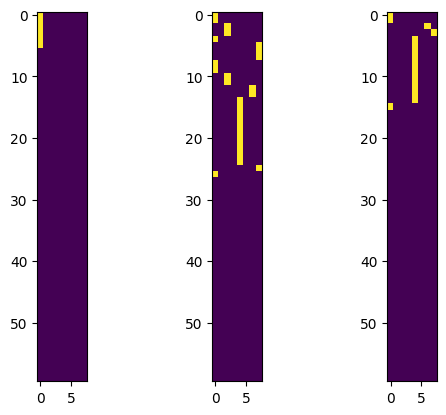

In [37]:
import matplotlib.pyplot as plt
# plt.figure(figsize = (2,4))
plt.subplot(131)
plt.imshow(dataset[0])
plt.subplot(132)
plt.imshow(dataset[1])
plt.subplot(133)
plt.imshow(dataset[2])
plt.show()

In [38]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [39]:
#VAE learn secondary structure
#VAE model
class VAE(nn.Module):
    def __init__(self, sequence_size=480, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(sequence_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) 
        self.fc3 = nn.Linear(h_dim, z_dim) 
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, sequence_size)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

def loss_function(x_reconst, x, mu, log_var):
    reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconst_loss, kl_div


model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

Epoch[1/1000], Step [10/145], Reconst Loss: 1467.5710, KL Div: 2.7969
Epoch[1/1000], Step [20/145], Reconst Loss: 575.7411, KL Div: 48.4340
Epoch[1/1000], Step [30/145], Reconst Loss: 409.8182, KL Div: 116.9749
Epoch[1/1000], Step [40/145], Reconst Loss: 267.8232, KL Div: 40.1009
Epoch[1/1000], Step [50/145], Reconst Loss: 297.6575, KL Div: 34.2716
Epoch[1/1000], Step [60/145], Reconst Loss: 283.5970, KL Div: 35.5699
Epoch[1/1000], Step [70/145], Reconst Loss: 321.7466, KL Div: 24.1132
Epoch[1/1000], Step [80/145], Reconst Loss: 235.9212, KL Div: 40.0344
Epoch[1/1000], Step [90/145], Reconst Loss: 203.3676, KL Div: 42.8341
Epoch[1/1000], Step [100/145], Reconst Loss: 272.4582, KL Div: 56.8979
Epoch[1/1000], Step [110/145], Reconst Loss: 233.4927, KL Div: 40.9672
Epoch[1/1000], Step [120/145], Reconst Loss: 177.9702, KL Div: 45.2880
Epoch[1/1000], Step [130/145], Reconst Loss: 257.3040, KL Div: 42.6212
Epoch[1/1000], Step [140/145], Reconst Loss: 219.2558, KL Div: 40.1880
Epoch[2/1000],

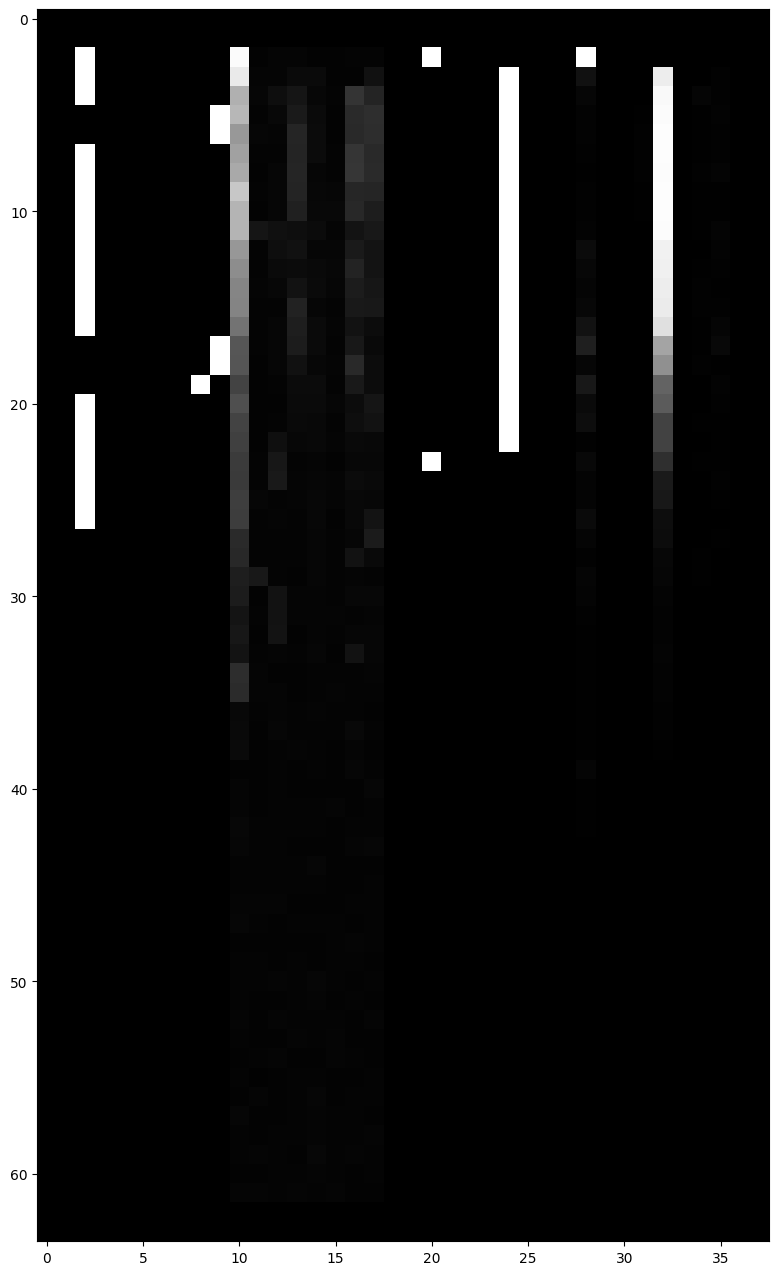

Epoch[3/1000], Step [10/145], Reconst Loss: 210.8031, KL Div: 34.2087
Epoch[3/1000], Step [20/145], Reconst Loss: 193.9311, KL Div: 24.6798
Epoch[3/1000], Step [30/145], Reconst Loss: 132.6284, KL Div: 33.9041
Epoch[3/1000], Step [40/145], Reconst Loss: 216.4112, KL Div: 42.4995
Epoch[3/1000], Step [50/145], Reconst Loss: 118.1259, KL Div: 34.5296
Epoch[3/1000], Step [60/145], Reconst Loss: 137.3863, KL Div: 33.5895
Epoch[3/1000], Step [70/145], Reconst Loss: 199.4131, KL Div: 25.5805
Epoch[3/1000], Step [80/145], Reconst Loss: 140.3353, KL Div: 34.4466
Epoch[3/1000], Step [90/145], Reconst Loss: 233.7996, KL Div: 34.3790
Epoch[3/1000], Step [100/145], Reconst Loss: 107.7946, KL Div: 36.1722
Epoch[3/1000], Step [110/145], Reconst Loss: 222.6322, KL Div: 28.9897
Epoch[3/1000], Step [120/145], Reconst Loss: 115.6793, KL Div: 31.0402
Epoch[3/1000], Step [130/145], Reconst Loss: 181.4307, KL Div: 29.5576
Epoch[3/1000], Step [140/145], Reconst Loss: 198.8073, KL Div: 32.4864
Epoch[4/1000], 

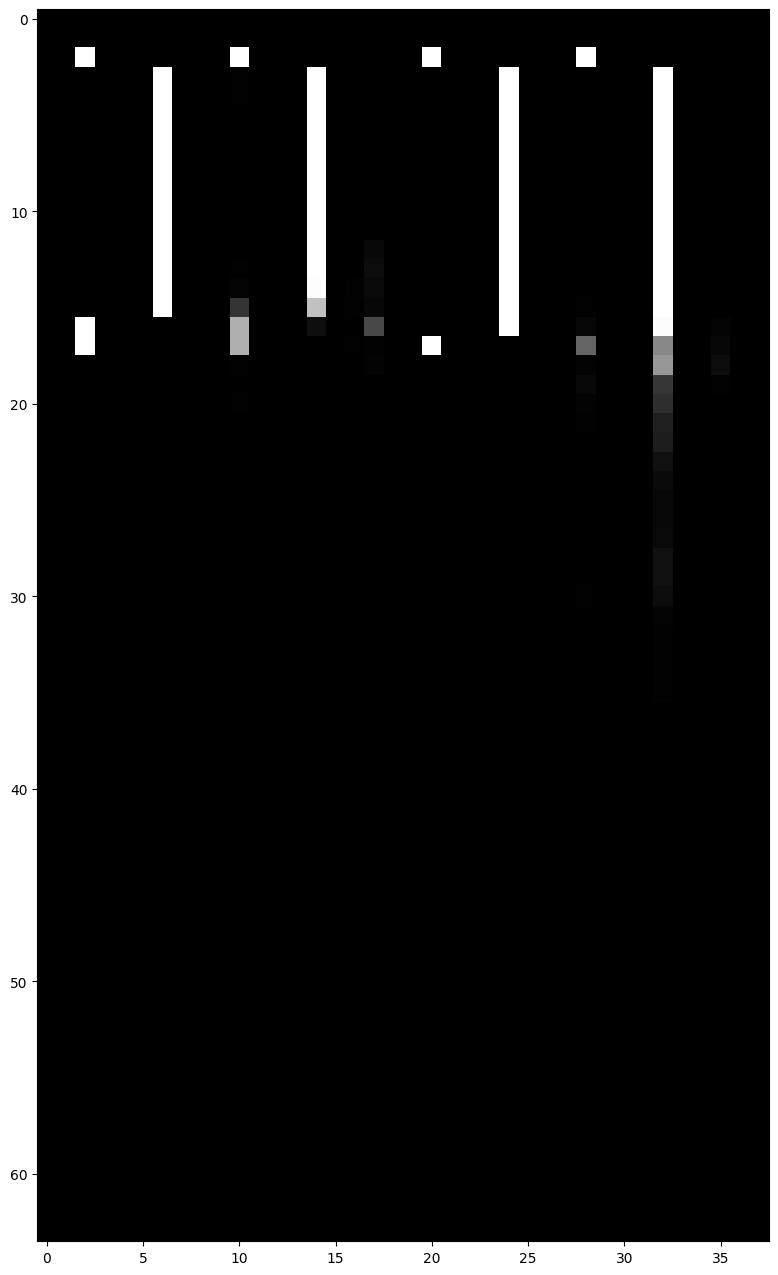

Epoch[28/1000], Step [10/145], Reconst Loss: 93.1069, KL Div: 66.3820
Epoch[28/1000], Step [20/145], Reconst Loss: 63.4584, KL Div: 53.7758
Epoch[28/1000], Step [30/145], Reconst Loss: 78.5200, KL Div: 64.8111
Epoch[28/1000], Step [40/145], Reconst Loss: 84.4143, KL Div: 46.8080
Epoch[28/1000], Step [50/145], Reconst Loss: 85.4752, KL Div: 53.7823
Epoch[28/1000], Step [60/145], Reconst Loss: 68.6673, KL Div: 45.7322
Epoch[28/1000], Step [70/145], Reconst Loss: 98.9431, KL Div: 65.0615
Epoch[28/1000], Step [80/145], Reconst Loss: 82.6830, KL Div: 52.9710
Epoch[28/1000], Step [90/145], Reconst Loss: 31.5826, KL Div: 43.3497
Epoch[28/1000], Step [100/145], Reconst Loss: 51.5999, KL Div: 49.1106
Epoch[28/1000], Step [110/145], Reconst Loss: 67.7431, KL Div: 49.7798
Epoch[28/1000], Step [120/145], Reconst Loss: 66.8318, KL Div: 47.2704
Epoch[28/1000], Step [130/145], Reconst Loss: 54.4551, KL Div: 53.2982
Epoch[28/1000], Step [140/145], Reconst Loss: 53.7736, KL Div: 49.3137
Epoch[29/1000],

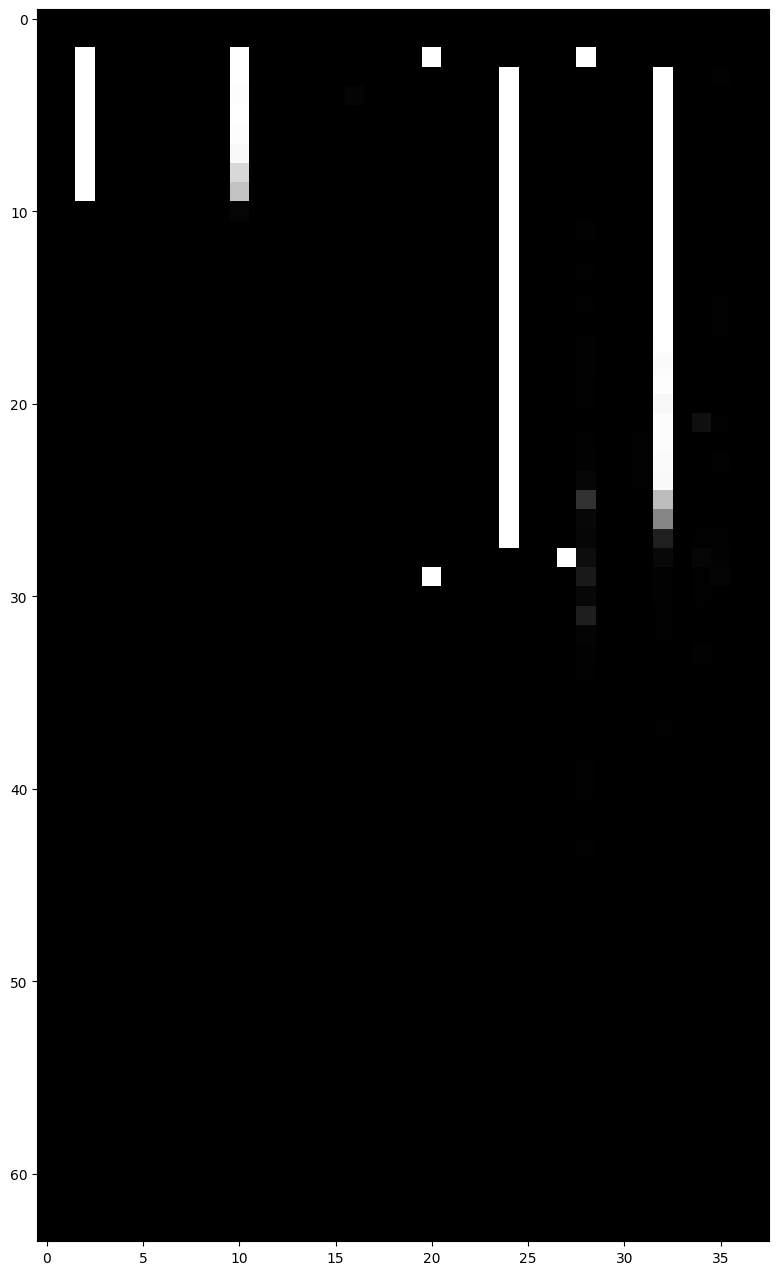

Epoch[53/1000], Step [10/145], Reconst Loss: 81.2123, KL Div: 65.2155
Epoch[53/1000], Step [20/145], Reconst Loss: 34.2404, KL Div: 50.3645
Epoch[53/1000], Step [30/145], Reconst Loss: 48.2255, KL Div: 62.4060
Epoch[53/1000], Step [40/145], Reconst Loss: 22.9539, KL Div: 44.2580
Epoch[53/1000], Step [50/145], Reconst Loss: 65.3041, KL Div: 59.4058
Epoch[53/1000], Step [60/145], Reconst Loss: 35.5945, KL Div: 52.7002
Epoch[53/1000], Step [70/145], Reconst Loss: 67.1841, KL Div: 62.1928
Epoch[53/1000], Step [80/145], Reconst Loss: 37.8757, KL Div: 51.3256
Epoch[53/1000], Step [90/145], Reconst Loss: 40.0091, KL Div: 53.6672
Epoch[53/1000], Step [100/145], Reconst Loss: 66.2322, KL Div: 55.4379
Epoch[53/1000], Step [110/145], Reconst Loss: 71.9505, KL Div: 58.8960
Epoch[53/1000], Step [120/145], Reconst Loss: 60.5787, KL Div: 61.7528
Epoch[53/1000], Step [130/145], Reconst Loss: 37.6798, KL Div: 61.4213
Epoch[53/1000], Step [140/145], Reconst Loss: 48.0754, KL Div: 73.5641
Epoch[54/1000],

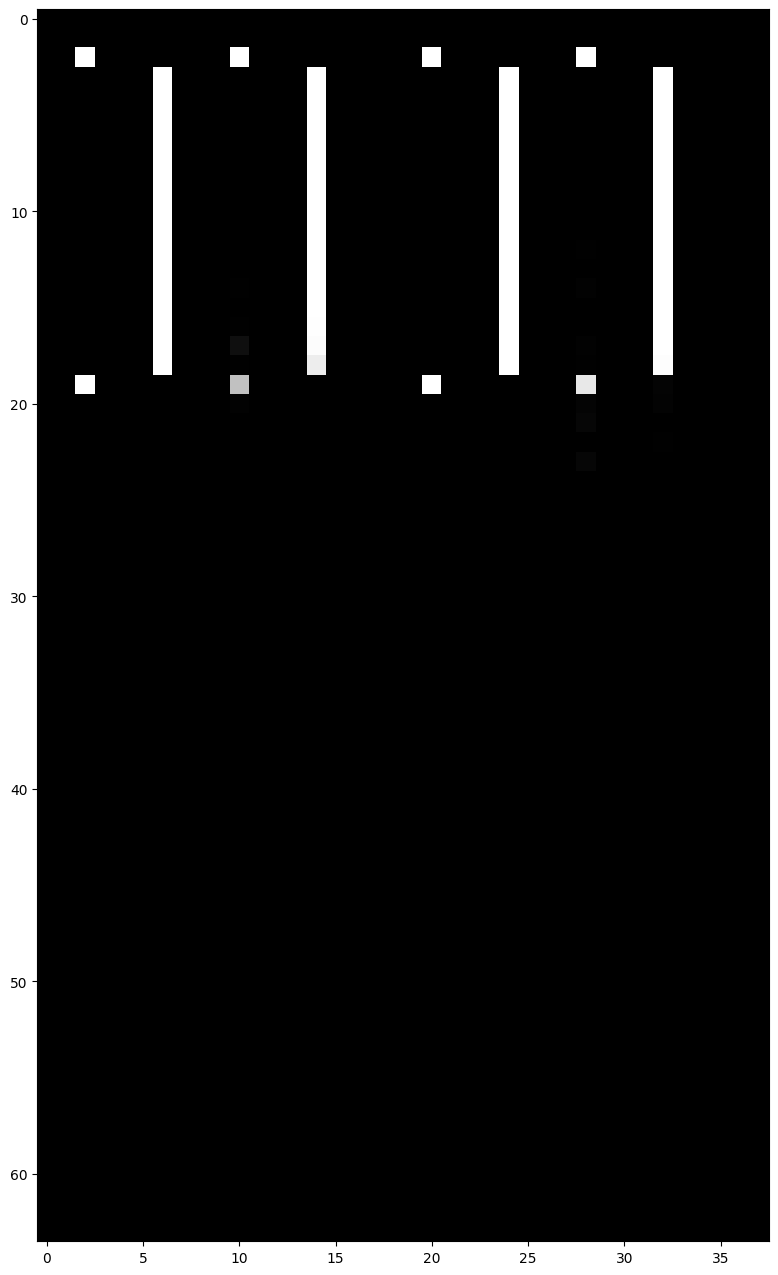

Epoch[78/1000], Step [10/145], Reconst Loss: 51.6859, KL Div: 48.4882
Epoch[78/1000], Step [20/145], Reconst Loss: 27.5887, KL Div: 57.0290
Epoch[78/1000], Step [30/145], Reconst Loss: 43.8375, KL Div: 59.2038
Epoch[78/1000], Step [40/145], Reconst Loss: 42.3595, KL Div: 46.9597
Epoch[78/1000], Step [50/145], Reconst Loss: 25.3060, KL Div: 56.9291
Epoch[78/1000], Step [60/145], Reconst Loss: 47.1163, KL Div: 82.6595
Epoch[78/1000], Step [70/145], Reconst Loss: 44.3085, KL Div: 74.3294
Epoch[78/1000], Step [80/145], Reconst Loss: 29.5086, KL Div: 59.6299
Epoch[78/1000], Step [90/145], Reconst Loss: 58.6432, KL Div: 82.0674
Epoch[78/1000], Step [100/145], Reconst Loss: 49.7327, KL Div: 57.6037
Epoch[78/1000], Step [110/145], Reconst Loss: 34.9400, KL Div: 70.8952
Epoch[78/1000], Step [120/145], Reconst Loss: 34.9156, KL Div: 64.1921
Epoch[78/1000], Step [130/145], Reconst Loss: 44.6450, KL Div: 41.2243
Epoch[78/1000], Step [140/145], Reconst Loss: 45.6436, KL Div: 68.9911
Epoch[79/1000],

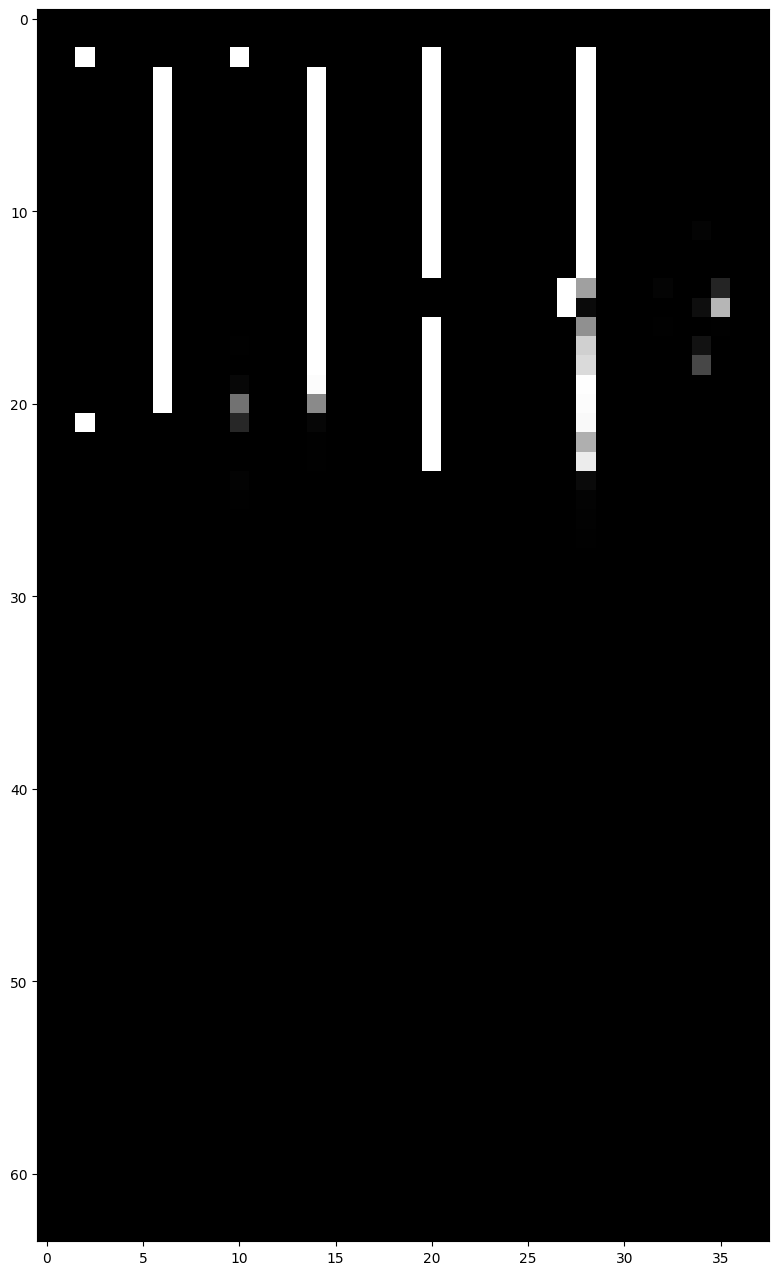

Epoch[103/1000], Step [10/145], Reconst Loss: 23.6182, KL Div: 54.0138
Epoch[103/1000], Step [20/145], Reconst Loss: 40.1327, KL Div: 58.3895
Epoch[103/1000], Step [30/145], Reconst Loss: 14.3579, KL Div: 43.7915
Epoch[103/1000], Step [40/145], Reconst Loss: 32.7507, KL Div: 42.4177
Epoch[103/1000], Step [50/145], Reconst Loss: 29.2411, KL Div: 47.2517
Epoch[103/1000], Step [60/145], Reconst Loss: 52.4395, KL Div: 79.6456
Epoch[103/1000], Step [70/145], Reconst Loss: 25.5977, KL Div: 58.8197
Epoch[103/1000], Step [80/145], Reconst Loss: 38.9375, KL Div: 50.7613
Epoch[103/1000], Step [90/145], Reconst Loss: 30.5127, KL Div: 56.7274
Epoch[103/1000], Step [100/145], Reconst Loss: 38.6181, KL Div: 69.7106
Epoch[103/1000], Step [110/145], Reconst Loss: 38.0611, KL Div: 72.8607
Epoch[103/1000], Step [120/145], Reconst Loss: 64.6638, KL Div: 86.2743
Epoch[103/1000], Step [130/145], Reconst Loss: 20.9843, KL Div: 49.4066
Epoch[103/1000], Step [140/145], Reconst Loss: 58.3904, KL Div: 78.4564
E

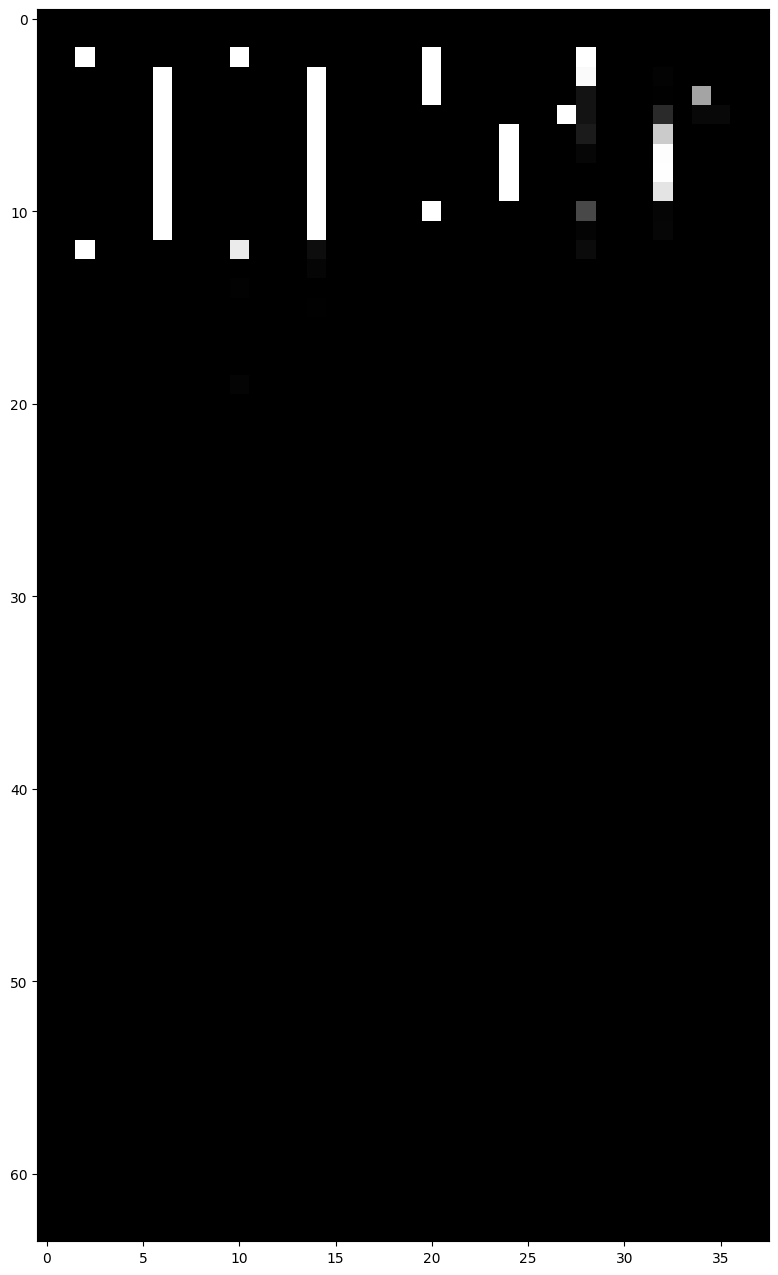

Epoch[128/1000], Step [10/145], Reconst Loss: 39.6111, KL Div: 69.8256
Epoch[128/1000], Step [20/145], Reconst Loss: 21.8560, KL Div: 60.3078
Epoch[128/1000], Step [30/145], Reconst Loss: 19.3028, KL Div: 53.8718
Epoch[128/1000], Step [40/145], Reconst Loss: 21.0242, KL Div: 64.5368
Epoch[128/1000], Step [50/145], Reconst Loss: 23.7675, KL Div: 62.3126
Epoch[128/1000], Step [60/145], Reconst Loss: 25.6981, KL Div: 73.1988
Epoch[128/1000], Step [70/145], Reconst Loss: 43.4434, KL Div: 74.7418
Epoch[128/1000], Step [80/145], Reconst Loss: 37.5773, KL Div: 54.1944
Epoch[128/1000], Step [90/145], Reconst Loss: 28.4587, KL Div: 71.7714
Epoch[128/1000], Step [100/145], Reconst Loss: 36.0052, KL Div: 62.7195
Epoch[128/1000], Step [110/145], Reconst Loss: 23.1705, KL Div: 52.4922
Epoch[128/1000], Step [120/145], Reconst Loss: 28.0705, KL Div: 55.8845
Epoch[128/1000], Step [130/145], Reconst Loss: 19.7085, KL Div: 60.1276
Epoch[128/1000], Step [140/145], Reconst Loss: 24.8463, KL Div: 70.5777
E

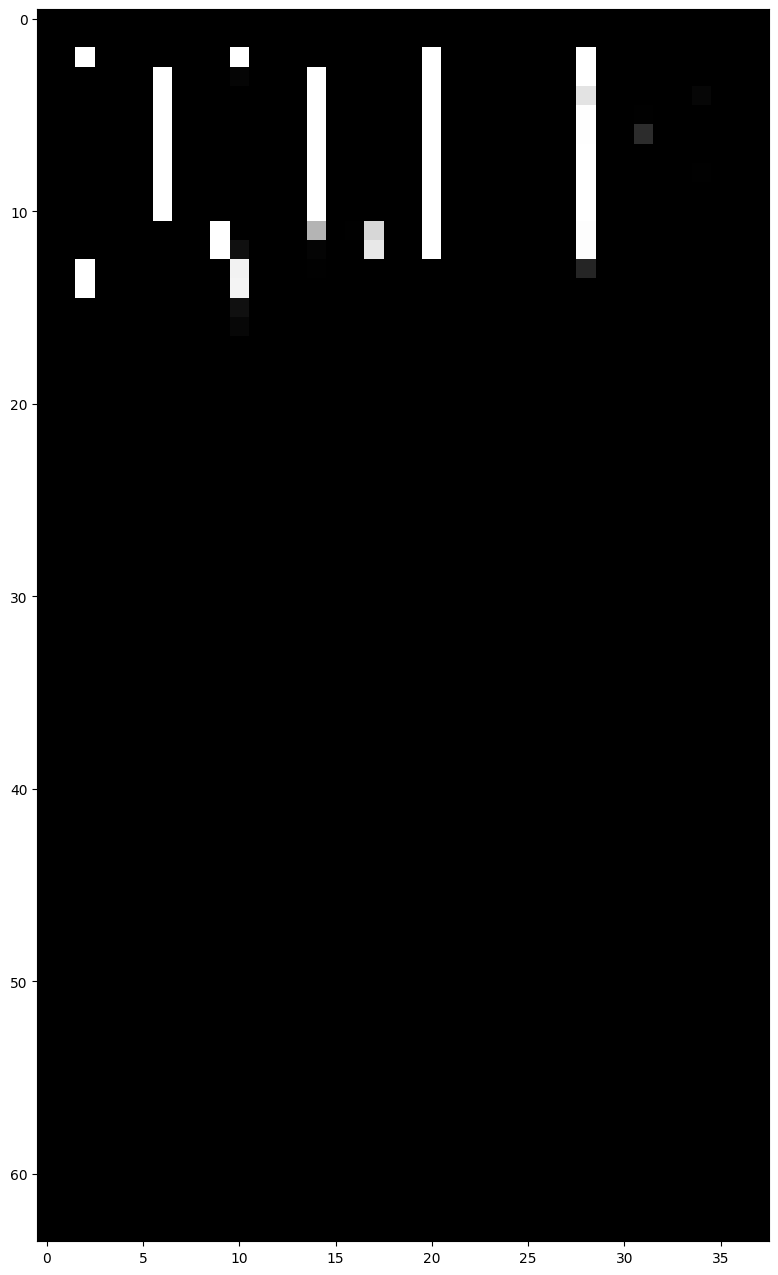

Epoch[153/1000], Step [10/145], Reconst Loss: 28.0877, KL Div: 40.1207
Epoch[153/1000], Step [20/145], Reconst Loss: 34.4113, KL Div: 69.4629
Epoch[153/1000], Step [30/145], Reconst Loss: 27.5061, KL Div: 61.2537
Epoch[153/1000], Step [40/145], Reconst Loss: 48.5340, KL Div: 40.7125
Epoch[153/1000], Step [50/145], Reconst Loss: 30.5515, KL Div: 55.1095
Epoch[153/1000], Step [60/145], Reconst Loss: 33.3214, KL Div: 64.3305
Epoch[153/1000], Step [70/145], Reconst Loss: 33.2169, KL Div: 67.4987
Epoch[153/1000], Step [80/145], Reconst Loss: 29.7139, KL Div: 67.4740
Epoch[153/1000], Step [90/145], Reconst Loss: 41.7864, KL Div: 79.4604
Epoch[153/1000], Step [100/145], Reconst Loss: 10.7360, KL Div: 47.4366
Epoch[153/1000], Step [110/145], Reconst Loss: 23.1244, KL Div: 64.6736
Epoch[153/1000], Step [120/145], Reconst Loss: 27.7764, KL Div: 68.3675
Epoch[153/1000], Step [130/145], Reconst Loss: 33.6758, KL Div: 78.9882
Epoch[153/1000], Step [140/145], Reconst Loss: 17.0100, KL Div: 53.8089
E

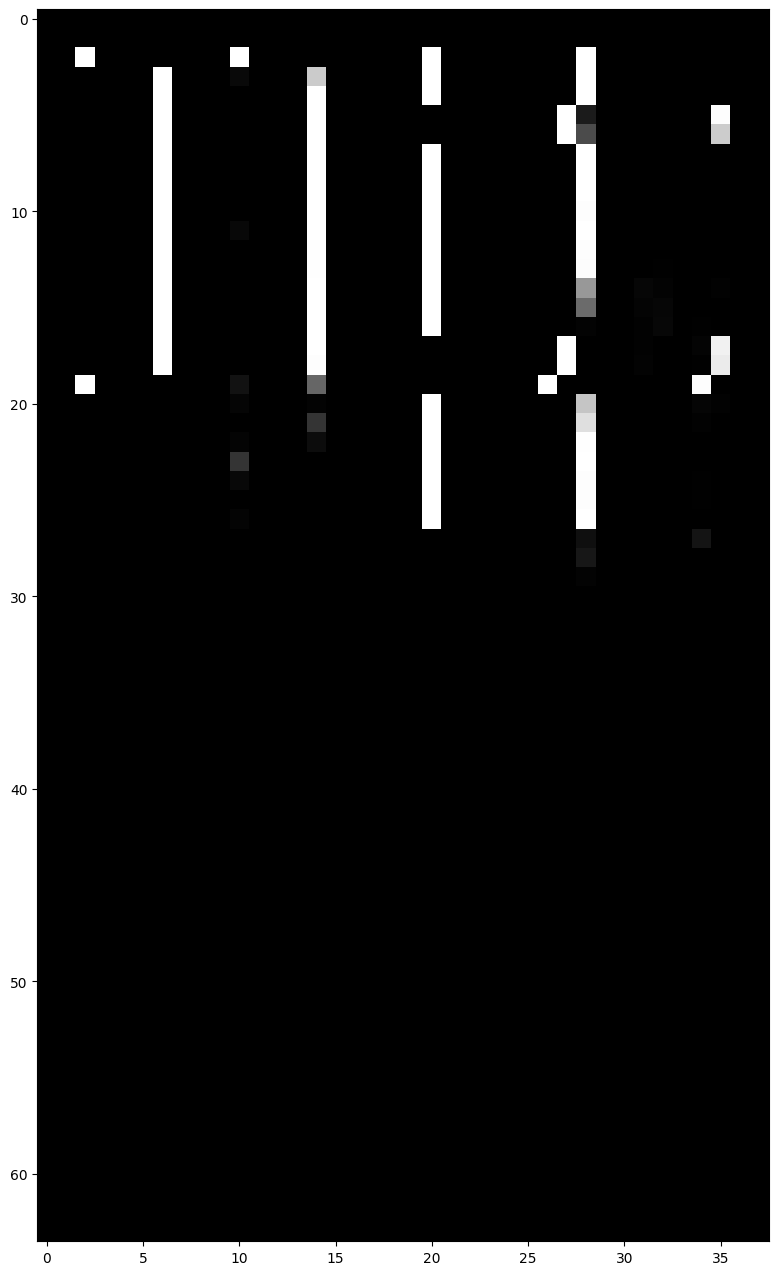

Epoch[178/1000], Step [10/145], Reconst Loss: 9.5760, KL Div: 43.0608
Epoch[178/1000], Step [20/145], Reconst Loss: 15.5751, KL Div: 56.8885
Epoch[178/1000], Step [30/145], Reconst Loss: 26.9739, KL Div: 60.0302
Epoch[178/1000], Step [40/145], Reconst Loss: 21.4013, KL Div: 77.9431
Epoch[178/1000], Step [50/145], Reconst Loss: 9.5413, KL Div: 62.0546
Epoch[178/1000], Step [60/145], Reconst Loss: 43.8258, KL Div: 74.2859
Epoch[178/1000], Step [70/145], Reconst Loss: 23.6939, KL Div: 53.8146
Epoch[178/1000], Step [80/145], Reconst Loss: 29.3653, KL Div: 53.9538
Epoch[178/1000], Step [90/145], Reconst Loss: 17.4964, KL Div: 73.9316
Epoch[178/1000], Step [100/145], Reconst Loss: 44.5843, KL Div: 64.7263
Epoch[178/1000], Step [110/145], Reconst Loss: 40.8115, KL Div: 80.6503
Epoch[178/1000], Step [120/145], Reconst Loss: 26.0361, KL Div: 60.1196
Epoch[178/1000], Step [130/145], Reconst Loss: 25.7137, KL Div: 65.9490
Epoch[178/1000], Step [140/145], Reconst Loss: 28.9680, KL Div: 61.7244
Epo

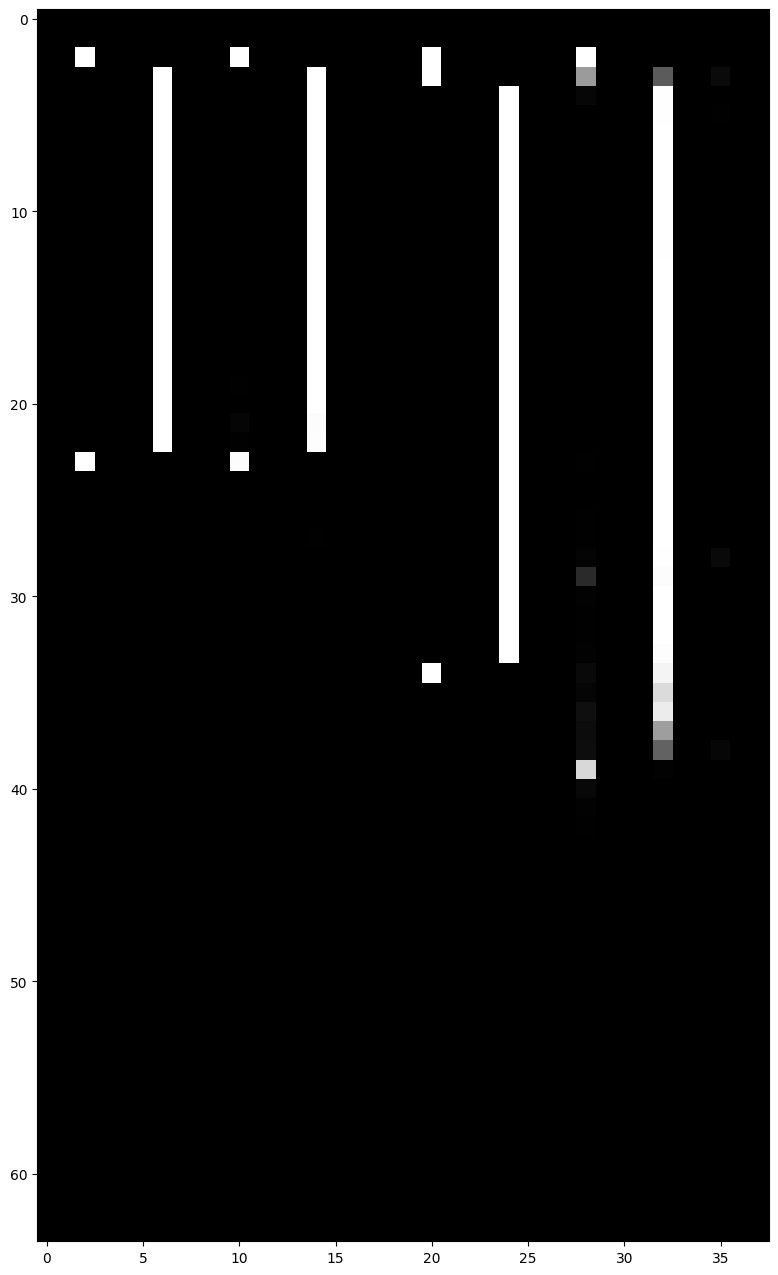

Epoch[203/1000], Step [10/145], Reconst Loss: 22.7773, KL Div: 57.1330
Epoch[203/1000], Step [20/145], Reconst Loss: 52.3891, KL Div: 67.3510
Epoch[203/1000], Step [30/145], Reconst Loss: 28.6213, KL Div: 63.3634
Epoch[203/1000], Step [40/145], Reconst Loss: 33.3162, KL Div: 66.3074
Epoch[203/1000], Step [50/145], Reconst Loss: 37.8096, KL Div: 64.7975
Epoch[203/1000], Step [60/145], Reconst Loss: 36.3131, KL Div: 66.1571
Epoch[203/1000], Step [70/145], Reconst Loss: 12.3533, KL Div: 68.6429
Epoch[203/1000], Step [80/145], Reconst Loss: 35.2686, KL Div: 78.9104
Epoch[203/1000], Step [90/145], Reconst Loss: 20.9479, KL Div: 71.6828
Epoch[203/1000], Step [100/145], Reconst Loss: 14.5163, KL Div: 54.3168
Epoch[203/1000], Step [110/145], Reconst Loss: 24.4745, KL Div: 62.7958
Epoch[203/1000], Step [120/145], Reconst Loss: 34.7447, KL Div: 57.2565
Epoch[203/1000], Step [130/145], Reconst Loss: 30.5305, KL Div: 70.2207
Epoch[203/1000], Step [140/145], Reconst Loss: 45.0234, KL Div: 86.1132
E

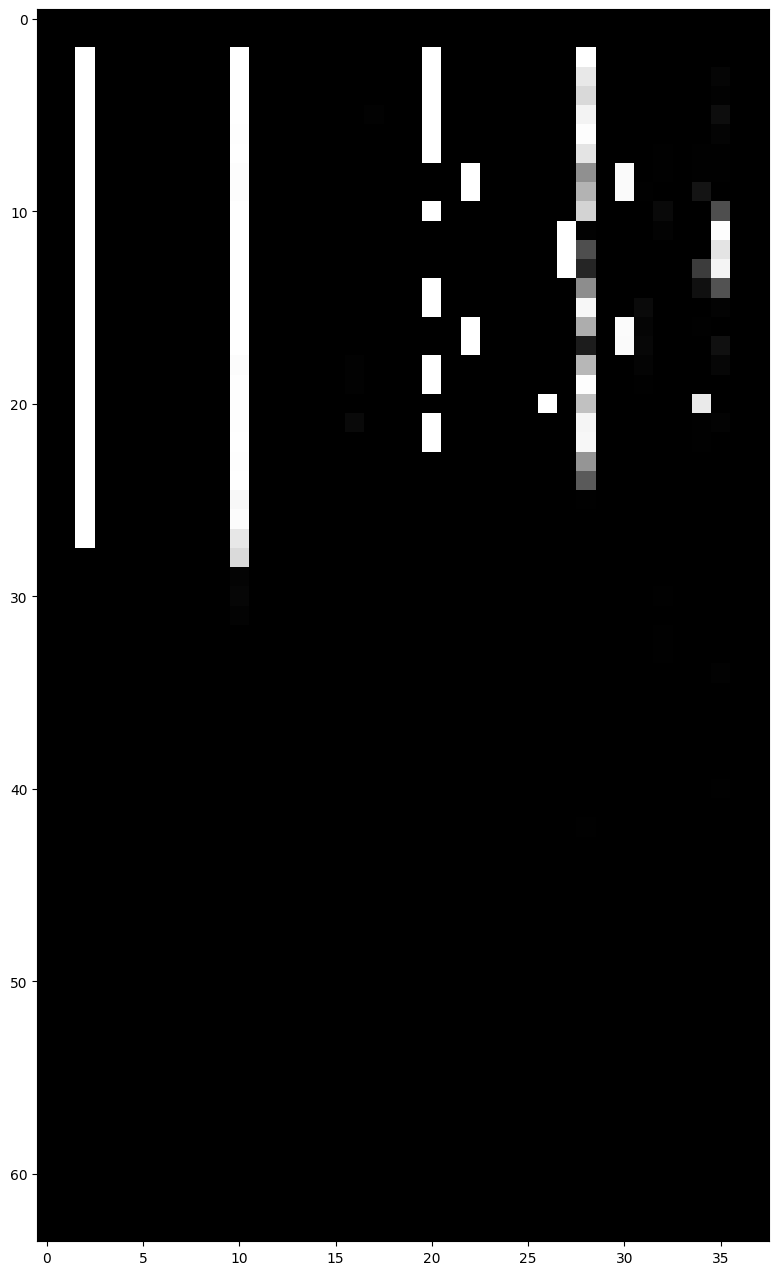

Epoch[228/1000], Step [10/145], Reconst Loss: 37.0018, KL Div: 81.2783
Epoch[228/1000], Step [20/145], Reconst Loss: 40.8236, KL Div: 79.8410
Epoch[228/1000], Step [30/145], Reconst Loss: 23.1005, KL Div: 55.0816
Epoch[228/1000], Step [40/145], Reconst Loss: 33.9883, KL Div: 66.3856
Epoch[228/1000], Step [50/145], Reconst Loss: 26.2611, KL Div: 62.7082
Epoch[228/1000], Step [60/145], Reconst Loss: 26.3908, KL Div: 63.9287
Epoch[228/1000], Step [70/145], Reconst Loss: 22.6357, KL Div: 52.3007
Epoch[228/1000], Step [80/145], Reconst Loss: 31.1068, KL Div: 71.2830
Epoch[228/1000], Step [90/145], Reconst Loss: 33.8222, KL Div: 68.9705
Epoch[228/1000], Step [100/145], Reconst Loss: 19.5368, KL Div: 63.8554
Epoch[228/1000], Step [110/145], Reconst Loss: 37.3028, KL Div: 82.3575
Epoch[228/1000], Step [120/145], Reconst Loss: 27.8097, KL Div: 69.5911
Epoch[228/1000], Step [130/145], Reconst Loss: 13.0135, KL Div: 48.1746
Epoch[228/1000], Step [140/145], Reconst Loss: 21.6993, KL Div: 57.8143
E

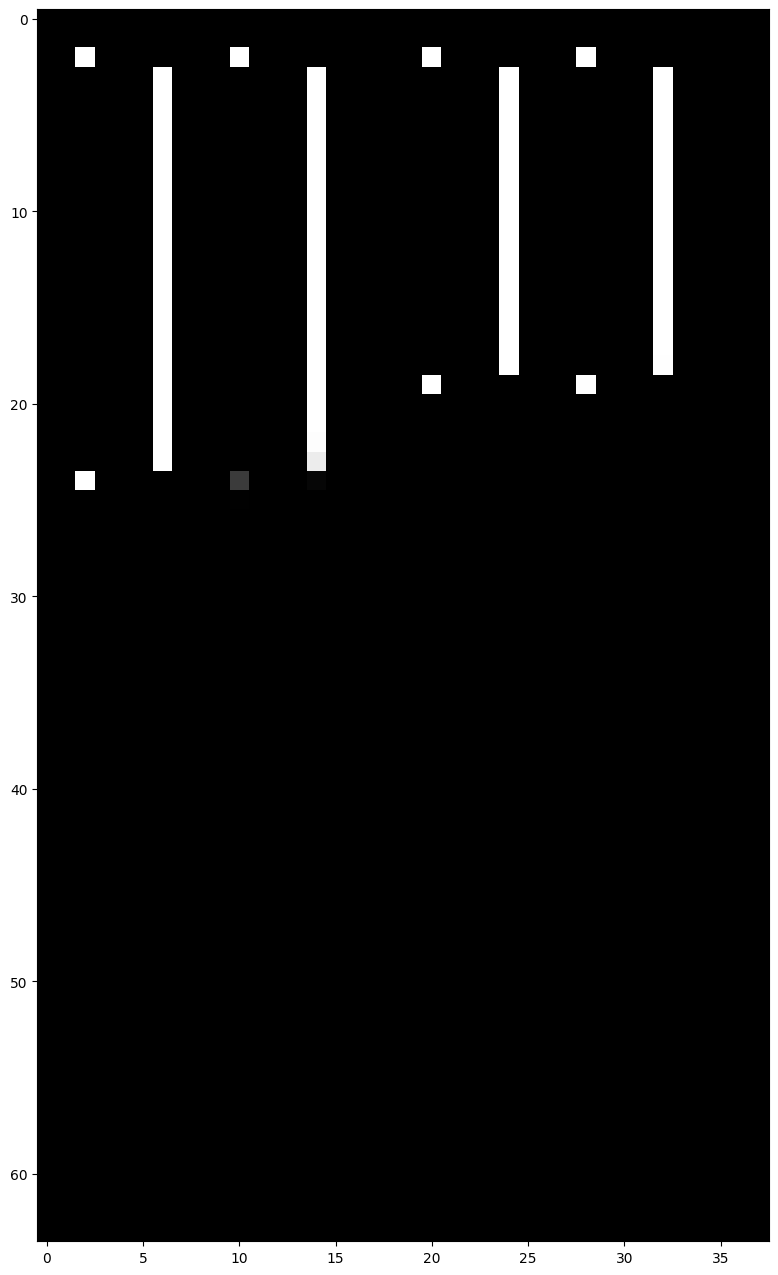

Epoch[253/1000], Step [10/145], Reconst Loss: 9.4980, KL Div: 54.8368
Epoch[253/1000], Step [20/145], Reconst Loss: 16.1091, KL Div: 72.7765
Epoch[253/1000], Step [30/145], Reconst Loss: 27.9107, KL Div: 59.8596
Epoch[253/1000], Step [40/145], Reconst Loss: 20.0268, KL Div: 55.9475
Epoch[253/1000], Step [50/145], Reconst Loss: 17.9296, KL Div: 55.4954
Epoch[253/1000], Step [60/145], Reconst Loss: 36.6546, KL Div: 67.1005
Epoch[253/1000], Step [70/145], Reconst Loss: 9.0840, KL Div: 66.6149
Epoch[253/1000], Step [80/145], Reconst Loss: 22.3029, KL Div: 69.8471
Epoch[253/1000], Step [90/145], Reconst Loss: 23.8975, KL Div: 53.6084
Epoch[253/1000], Step [100/145], Reconst Loss: 22.0040, KL Div: 62.7917
Epoch[253/1000], Step [110/145], Reconst Loss: 23.9287, KL Div: 53.8679
Epoch[253/1000], Step [120/145], Reconst Loss: 30.8974, KL Div: 74.4859
Epoch[253/1000], Step [130/145], Reconst Loss: 15.5701, KL Div: 61.8737
Epoch[253/1000], Step [140/145], Reconst Loss: 47.2392, KL Div: 58.5168
Epo

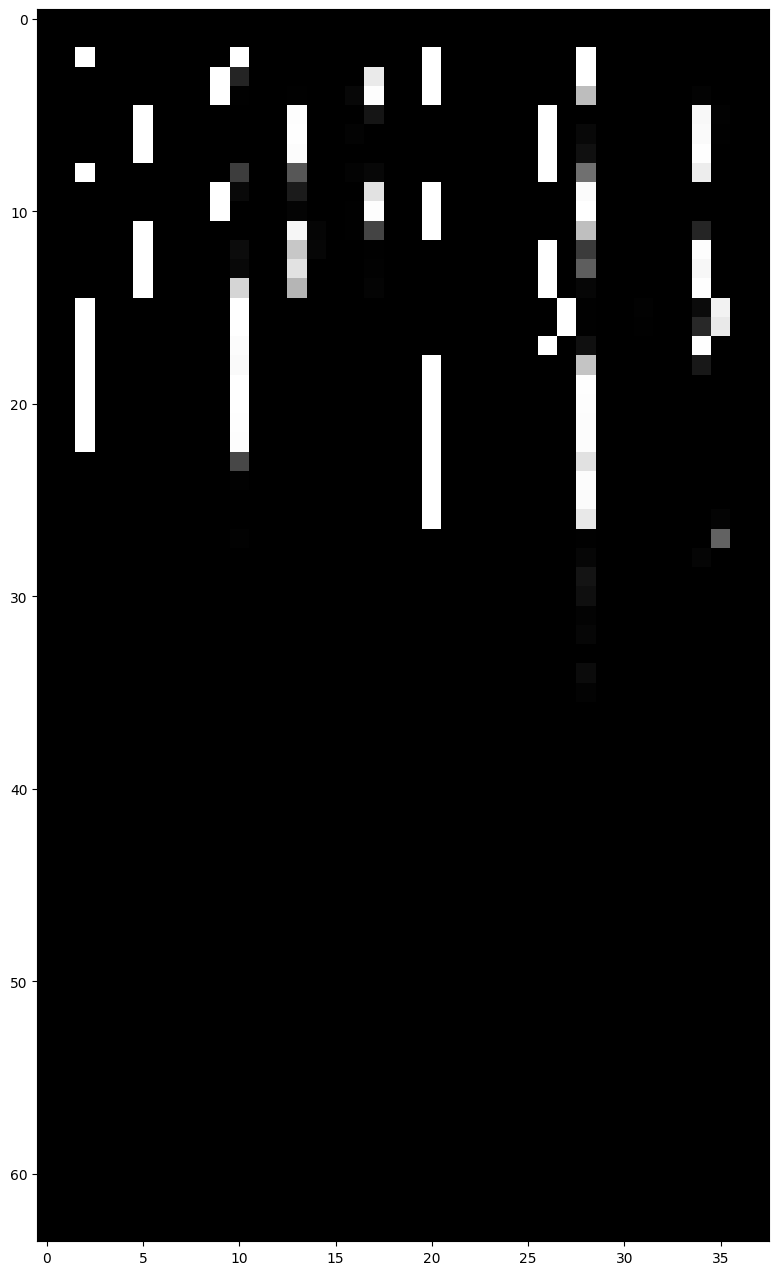

Epoch[278/1000], Step [10/145], Reconst Loss: 29.2126, KL Div: 68.8960
Epoch[278/1000], Step [20/145], Reconst Loss: 24.2599, KL Div: 85.8853
Epoch[278/1000], Step [30/145], Reconst Loss: 24.3763, KL Div: 63.8936
Epoch[278/1000], Step [40/145], Reconst Loss: 31.0730, KL Div: 52.3586
Epoch[278/1000], Step [50/145], Reconst Loss: 26.1790, KL Div: 71.6266
Epoch[278/1000], Step [60/145], Reconst Loss: 26.3281, KL Div: 89.2468
Epoch[278/1000], Step [70/145], Reconst Loss: 18.7602, KL Div: 65.3703
Epoch[278/1000], Step [80/145], Reconst Loss: 21.3429, KL Div: 52.9049
Epoch[278/1000], Step [90/145], Reconst Loss: 40.5534, KL Div: 70.4862
Epoch[278/1000], Step [100/145], Reconst Loss: 28.1019, KL Div: 67.0537
Epoch[278/1000], Step [110/145], Reconst Loss: 25.5071, KL Div: 62.3030
Epoch[278/1000], Step [120/145], Reconst Loss: 15.4584, KL Div: 52.1563
Epoch[278/1000], Step [130/145], Reconst Loss: 19.1528, KL Div: 64.9042
Epoch[278/1000], Step [140/145], Reconst Loss: 14.0244, KL Div: 58.2416
E

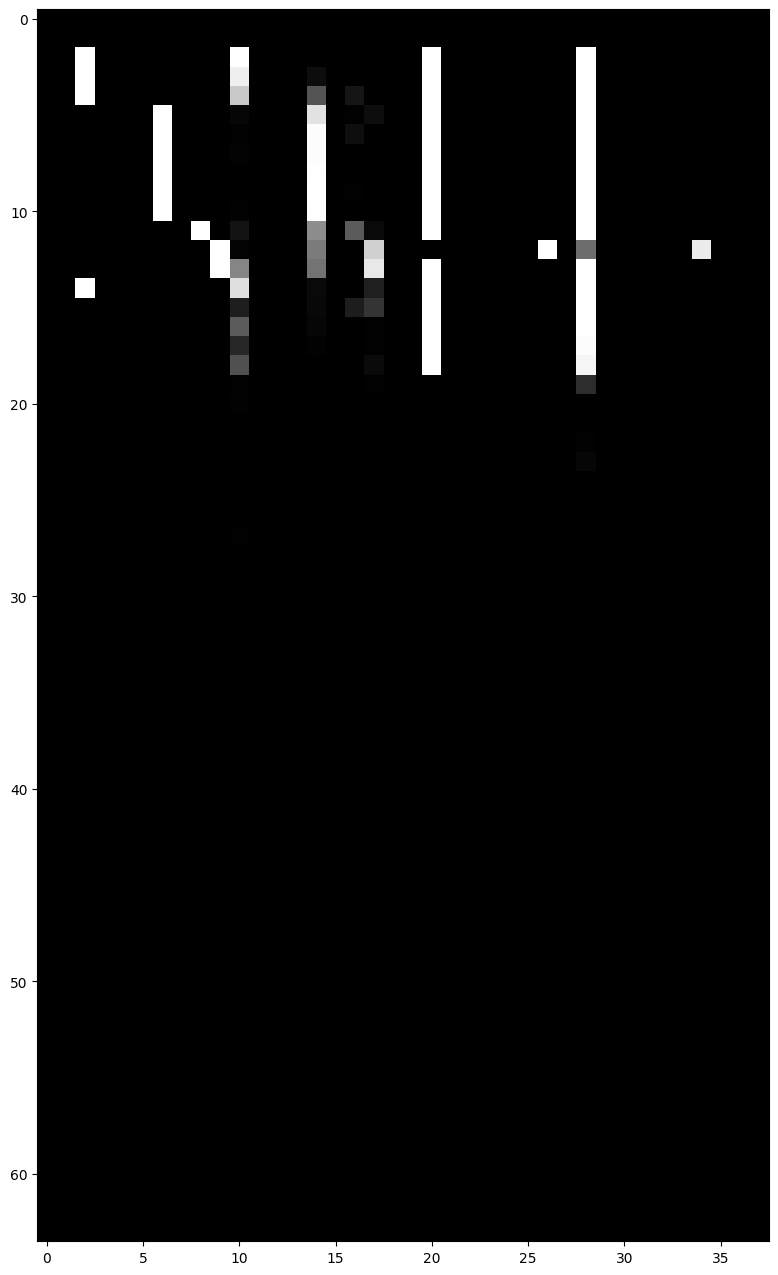

Epoch[303/1000], Step [10/145], Reconst Loss: 16.2723, KL Div: 59.6624
Epoch[303/1000], Step [20/145], Reconst Loss: 15.8492, KL Div: 48.5673
Epoch[303/1000], Step [30/145], Reconst Loss: 42.9480, KL Div: 61.5153
Epoch[303/1000], Step [40/145], Reconst Loss: 28.9350, KL Div: 67.4092
Epoch[303/1000], Step [50/145], Reconst Loss: 22.9147, KL Div: 56.4110
Epoch[303/1000], Step [60/145], Reconst Loss: 23.3674, KL Div: 60.3525
Epoch[303/1000], Step [70/145], Reconst Loss: 33.0224, KL Div: 63.5208
Epoch[303/1000], Step [80/145], Reconst Loss: 34.8529, KL Div: 81.1043
Epoch[303/1000], Step [90/145], Reconst Loss: 18.2435, KL Div: 57.2740
Epoch[303/1000], Step [100/145], Reconst Loss: 38.7860, KL Div: 67.0337
Epoch[303/1000], Step [110/145], Reconst Loss: 18.9212, KL Div: 78.0374
Epoch[303/1000], Step [120/145], Reconst Loss: 25.3864, KL Div: 58.0829
Epoch[303/1000], Step [130/145], Reconst Loss: 24.8591, KL Div: 63.5005
Epoch[303/1000], Step [140/145], Reconst Loss: 26.4029, KL Div: 52.3656
E

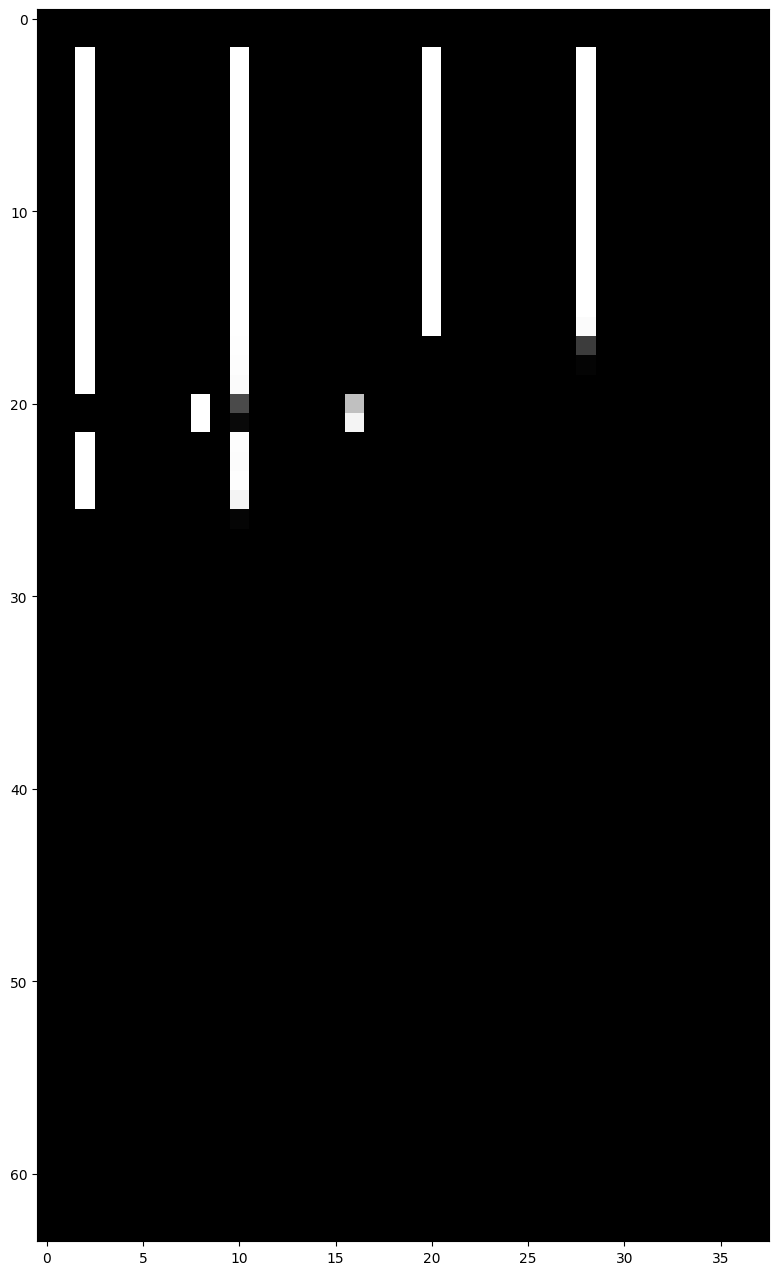

Epoch[328/1000], Step [10/145], Reconst Loss: 33.0809, KL Div: 69.1477
Epoch[328/1000], Step [20/145], Reconst Loss: 44.8161, KL Div: 69.4668
Epoch[328/1000], Step [30/145], Reconst Loss: 14.9463, KL Div: 54.9232
Epoch[328/1000], Step [40/145], Reconst Loss: 24.3328, KL Div: 62.0251
Epoch[328/1000], Step [50/145], Reconst Loss: 25.2823, KL Div: 65.6943
Epoch[328/1000], Step [60/145], Reconst Loss: 13.9440, KL Div: 69.5118
Epoch[328/1000], Step [70/145], Reconst Loss: 28.5390, KL Div: 80.9958
Epoch[328/1000], Step [80/145], Reconst Loss: 16.7896, KL Div: 70.3061
Epoch[328/1000], Step [90/145], Reconst Loss: 22.9325, KL Div: 69.1777
Epoch[328/1000], Step [100/145], Reconst Loss: 12.4472, KL Div: 75.8718
Epoch[328/1000], Step [110/145], Reconst Loss: 41.2400, KL Div: 66.4168
Epoch[328/1000], Step [120/145], Reconst Loss: 33.6644, KL Div: 70.1035
Epoch[328/1000], Step [130/145], Reconst Loss: 11.7677, KL Div: 43.1785
Epoch[328/1000], Step [140/145], Reconst Loss: 35.4533, KL Div: 52.6753
E

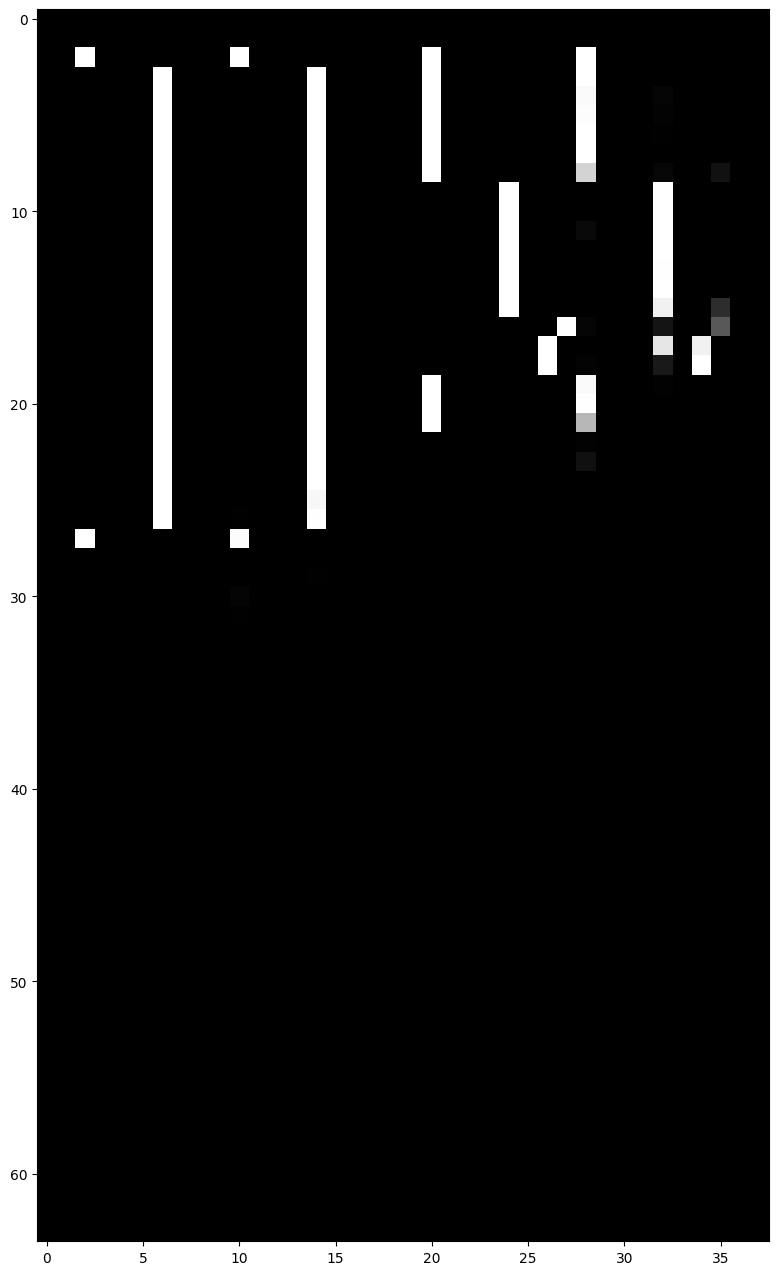

Epoch[353/1000], Step [10/145], Reconst Loss: 24.8238, KL Div: 63.3977
Epoch[353/1000], Step [20/145], Reconst Loss: 15.8205, KL Div: 63.3463
Epoch[353/1000], Step [30/145], Reconst Loss: 10.3196, KL Div: 65.0812
Epoch[353/1000], Step [40/145], Reconst Loss: 12.3588, KL Div: 65.9913
Epoch[353/1000], Step [50/145], Reconst Loss: 16.4413, KL Div: 71.6695
Epoch[353/1000], Step [60/145], Reconst Loss: 13.8759, KL Div: 60.9014
Epoch[353/1000], Step [70/145], Reconst Loss: 10.9723, KL Div: 49.8940
Epoch[353/1000], Step [80/145], Reconst Loss: 23.7602, KL Div: 64.5474
Epoch[353/1000], Step [90/145], Reconst Loss: 17.5021, KL Div: 70.8407
Epoch[353/1000], Step [100/145], Reconst Loss: 11.3908, KL Div: 60.5918
Epoch[353/1000], Step [110/145], Reconst Loss: 18.9961, KL Div: 64.5397
Epoch[353/1000], Step [120/145], Reconst Loss: 13.9936, KL Div: 54.2944
Epoch[353/1000], Step [130/145], Reconst Loss: 30.7367, KL Div: 77.5582
Epoch[353/1000], Step [140/145], Reconst Loss: 19.5472, KL Div: 55.8129
E

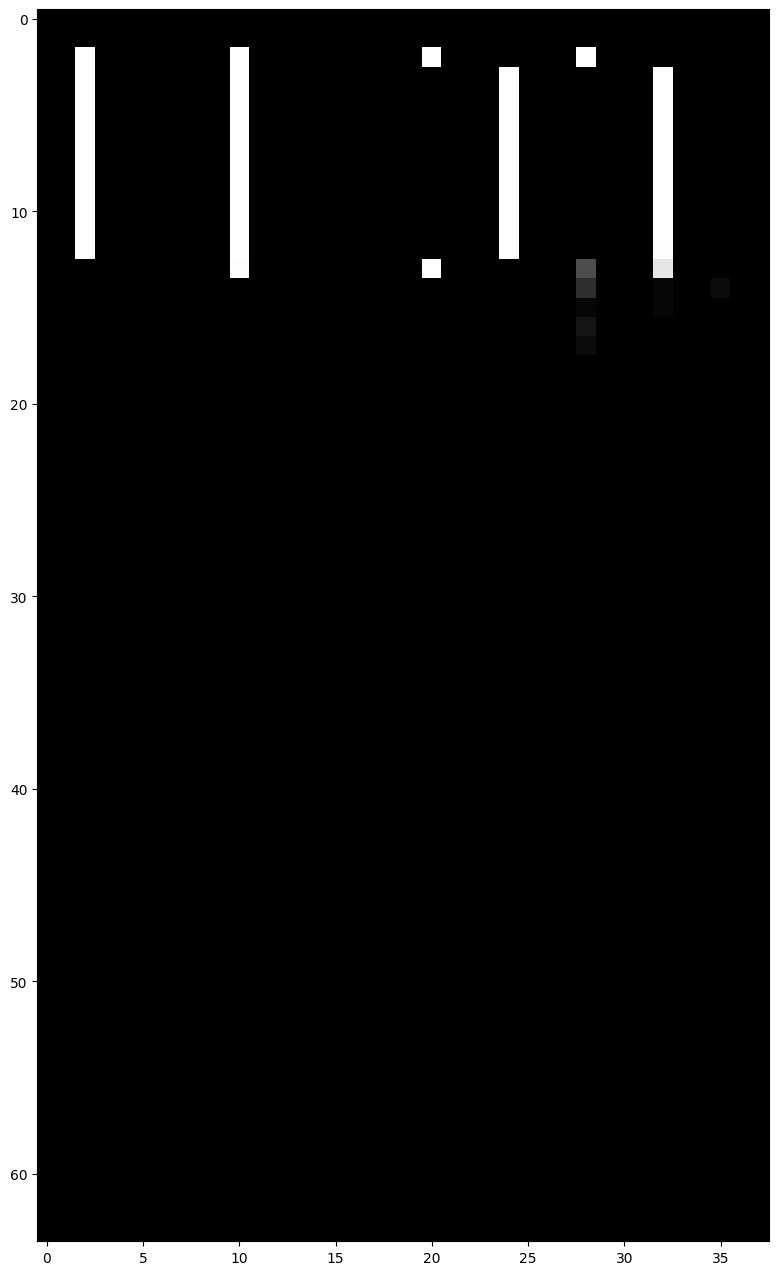

Epoch[378/1000], Step [10/145], Reconst Loss: 20.2037, KL Div: 65.7433
Epoch[378/1000], Step [20/145], Reconst Loss: 15.8484, KL Div: 90.4127
Epoch[378/1000], Step [30/145], Reconst Loss: 14.4473, KL Div: 52.6015
Epoch[378/1000], Step [40/145], Reconst Loss: 24.5973, KL Div: 65.2985
Epoch[378/1000], Step [50/145], Reconst Loss: 18.0169, KL Div: 70.3134
Epoch[378/1000], Step [60/145], Reconst Loss: 21.1063, KL Div: 53.8381
Epoch[378/1000], Step [70/145], Reconst Loss: 14.3234, KL Div: 63.2003
Epoch[378/1000], Step [80/145], Reconst Loss: 14.8915, KL Div: 58.1456
Epoch[378/1000], Step [90/145], Reconst Loss: 16.1285, KL Div: 56.6544
Epoch[378/1000], Step [100/145], Reconst Loss: 34.2756, KL Div: 67.2406
Epoch[378/1000], Step [110/145], Reconst Loss: 22.1906, KL Div: 72.5997
Epoch[378/1000], Step [120/145], Reconst Loss: 16.8755, KL Div: 48.7722
Epoch[378/1000], Step [130/145], Reconst Loss: 31.6288, KL Div: 65.0721
Epoch[378/1000], Step [140/145], Reconst Loss: 19.1415, KL Div: 76.0787
E

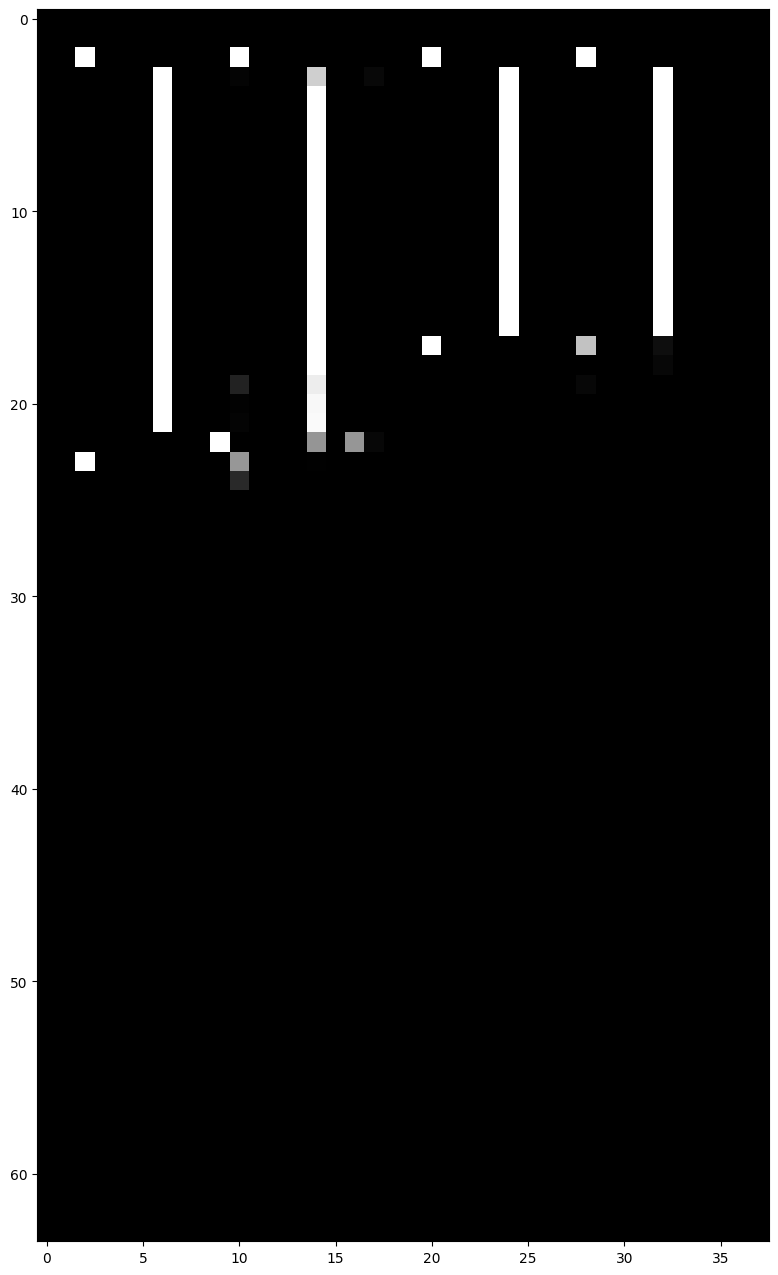

Epoch[403/1000], Step [10/145], Reconst Loss: 29.9676, KL Div: 58.1655
Epoch[403/1000], Step [20/145], Reconst Loss: 17.2955, KL Div: 68.7843
Epoch[403/1000], Step [30/145], Reconst Loss: 24.1983, KL Div: 62.0983
Epoch[403/1000], Step [40/145], Reconst Loss: 15.5813, KL Div: 84.8817
Epoch[403/1000], Step [50/145], Reconst Loss: 24.8211, KL Div: 78.0825
Epoch[403/1000], Step [60/145], Reconst Loss: 15.7052, KL Div: 62.9753
Epoch[403/1000], Step [70/145], Reconst Loss: 18.4278, KL Div: 51.1735
Epoch[403/1000], Step [80/145], Reconst Loss: 21.5388, KL Div: 72.7604
Epoch[403/1000], Step [90/145], Reconst Loss: 22.6418, KL Div: 68.2540
Epoch[403/1000], Step [100/145], Reconst Loss: 27.6696, KL Div: 69.4022
Epoch[403/1000], Step [110/145], Reconst Loss: 15.5949, KL Div: 71.8160
Epoch[403/1000], Step [120/145], Reconst Loss: 18.9909, KL Div: 76.3901
Epoch[403/1000], Step [130/145], Reconst Loss: 14.8518, KL Div: 54.7641
Epoch[403/1000], Step [140/145], Reconst Loss: 13.8174, KL Div: 55.1652
E

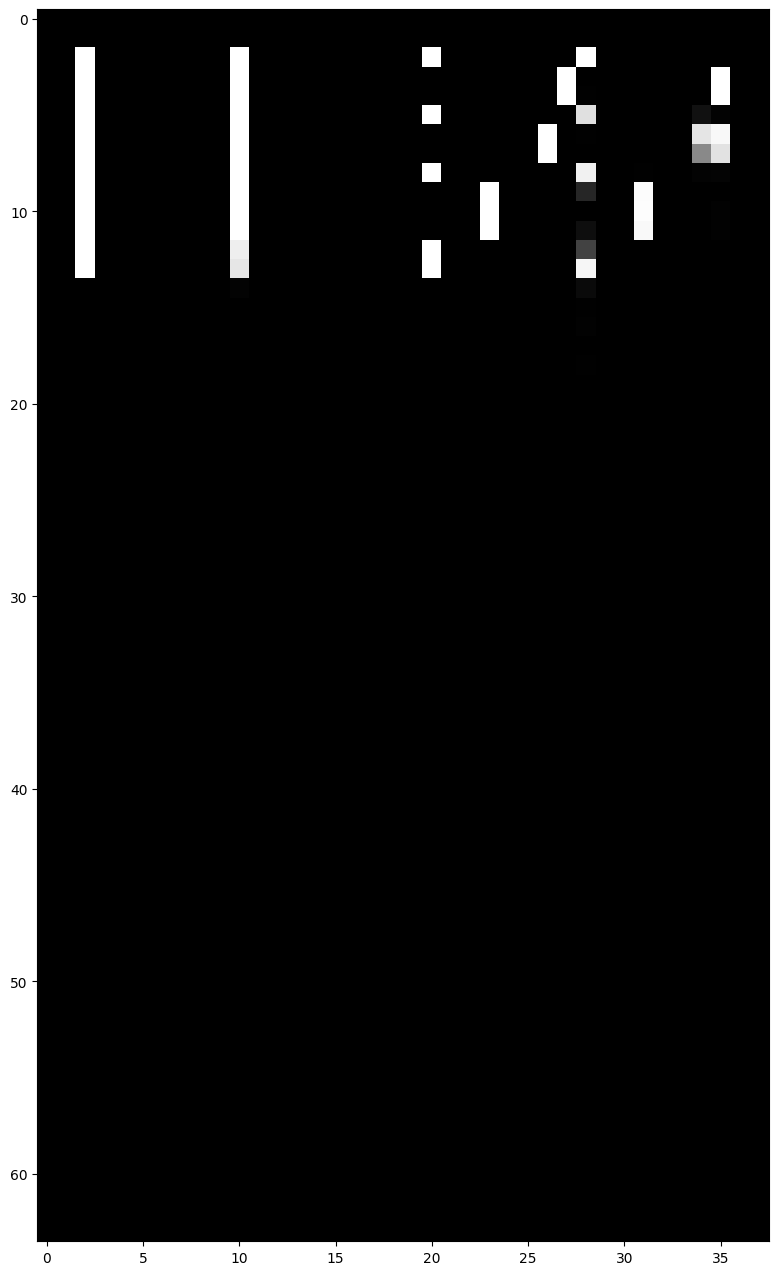

Epoch[428/1000], Step [10/145], Reconst Loss: 15.5323, KL Div: 51.2498
Epoch[428/1000], Step [20/145], Reconst Loss: 30.9582, KL Div: 61.5023
Epoch[428/1000], Step [30/145], Reconst Loss: 18.1258, KL Div: 60.1535
Epoch[428/1000], Step [40/145], Reconst Loss: 11.7027, KL Div: 60.4525
Epoch[428/1000], Step [50/145], Reconst Loss: 27.5161, KL Div: 55.0762
Epoch[428/1000], Step [60/145], Reconst Loss: 8.4975, KL Div: 59.7013
Epoch[428/1000], Step [70/145], Reconst Loss: 23.2641, KL Div: 77.3252
Epoch[428/1000], Step [80/145], Reconst Loss: 22.1947, KL Div: 68.6105
Epoch[428/1000], Step [90/145], Reconst Loss: 20.5972, KL Div: 86.7762
Epoch[428/1000], Step [100/145], Reconst Loss: 18.4375, KL Div: 70.7722
Epoch[428/1000], Step [110/145], Reconst Loss: 40.3671, KL Div: 77.7575
Epoch[428/1000], Step [120/145], Reconst Loss: 16.9459, KL Div: 88.2702
Epoch[428/1000], Step [130/145], Reconst Loss: 10.8348, KL Div: 54.7597
Epoch[428/1000], Step [140/145], Reconst Loss: 11.3112, KL Div: 72.3768
Ep

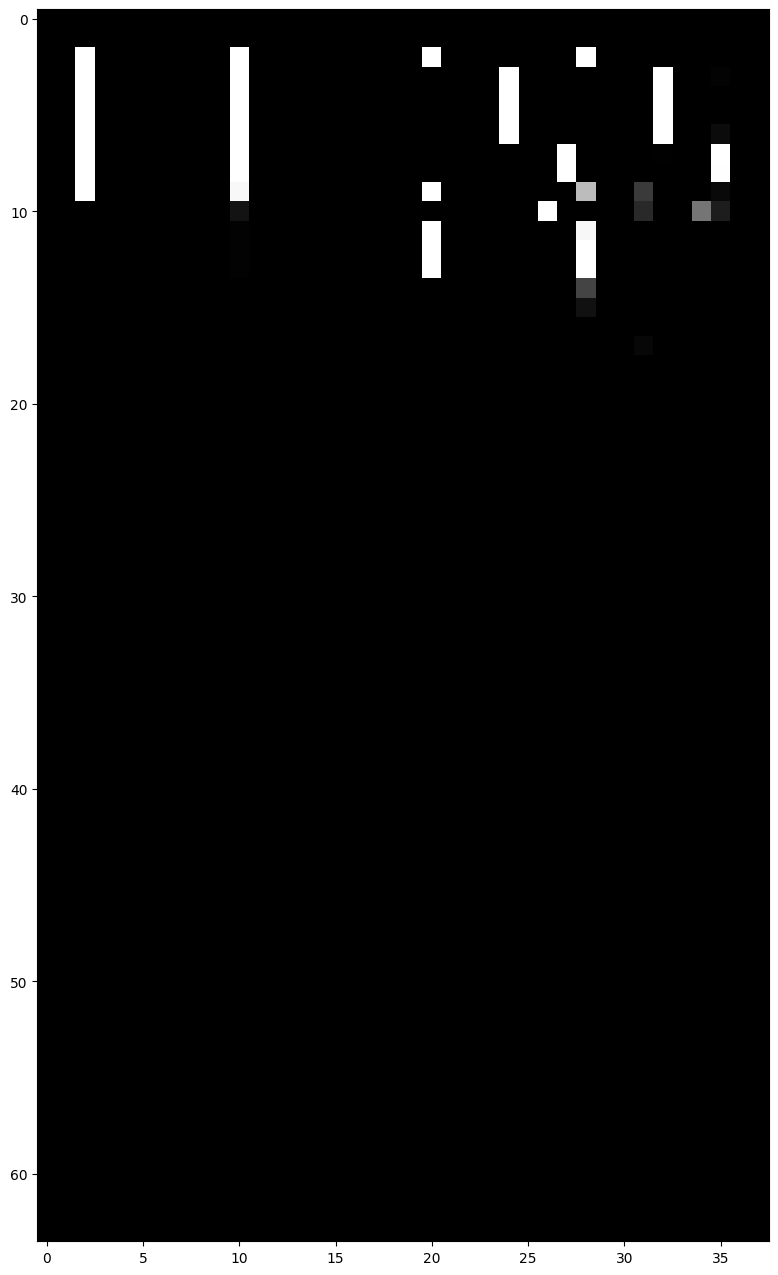

Epoch[453/1000], Step [10/145], Reconst Loss: 10.5354, KL Div: 54.9327
Epoch[453/1000], Step [20/145], Reconst Loss: 20.6191, KL Div: 65.4357
Epoch[453/1000], Step [30/145], Reconst Loss: 22.1446, KL Div: 85.2197
Epoch[453/1000], Step [40/145], Reconst Loss: 20.2894, KL Div: 75.2675
Epoch[453/1000], Step [50/145], Reconst Loss: 16.0227, KL Div: 63.6794
Epoch[453/1000], Step [60/145], Reconst Loss: 16.7315, KL Div: 64.1470
Epoch[453/1000], Step [70/145], Reconst Loss: 12.4622, KL Div: 56.5796
Epoch[453/1000], Step [80/145], Reconst Loss: 26.1162, KL Div: 90.4604
Epoch[453/1000], Step [90/145], Reconst Loss: 43.4322, KL Div: 63.8367
Epoch[453/1000], Step [100/145], Reconst Loss: 20.4904, KL Div: 71.6827
Epoch[453/1000], Step [110/145], Reconst Loss: 10.4028, KL Div: 71.7934
Epoch[453/1000], Step [120/145], Reconst Loss: 21.8134, KL Div: 70.0024
Epoch[453/1000], Step [130/145], Reconst Loss: 18.2587, KL Div: 87.4776
Epoch[453/1000], Step [140/145], Reconst Loss: 32.2984, KL Div: 68.6898
E

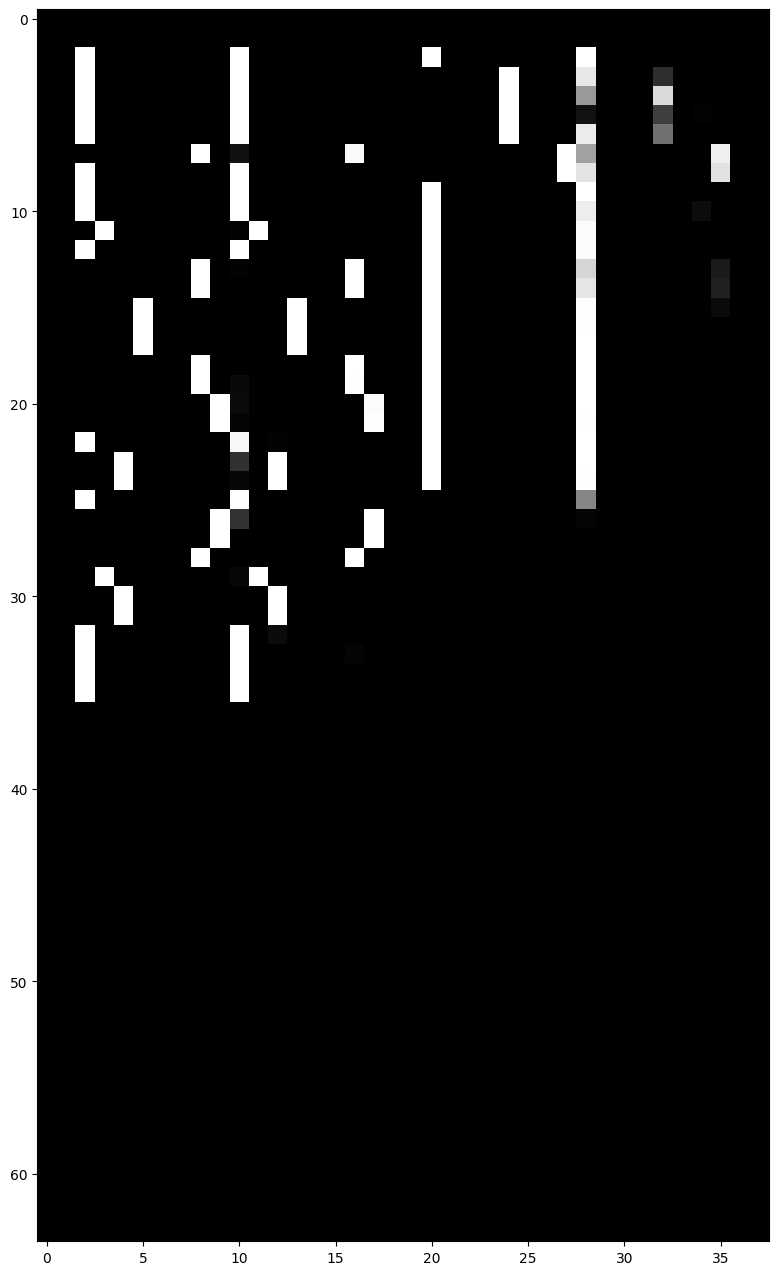

Epoch[478/1000], Step [10/145], Reconst Loss: 15.9353, KL Div: 64.0771
Epoch[478/1000], Step [20/145], Reconst Loss: 30.9747, KL Div: 54.5078
Epoch[478/1000], Step [30/145], Reconst Loss: 33.4150, KL Div: 71.6508
Epoch[478/1000], Step [40/145], Reconst Loss: 16.2929, KL Div: 78.3370
Epoch[478/1000], Step [50/145], Reconst Loss: 17.7605, KL Div: 55.9483
Epoch[478/1000], Step [60/145], Reconst Loss: 26.6785, KL Div: 72.5308
Epoch[478/1000], Step [70/145], Reconst Loss: 14.2885, KL Div: 67.1050
Epoch[478/1000], Step [80/145], Reconst Loss: 18.4290, KL Div: 68.7324
Epoch[478/1000], Step [90/145], Reconst Loss: 23.4773, KL Div: 70.6153
Epoch[478/1000], Step [100/145], Reconst Loss: 4.2983, KL Div: 42.1053
Epoch[478/1000], Step [110/145], Reconst Loss: 20.3465, KL Div: 63.3353
Epoch[478/1000], Step [120/145], Reconst Loss: 16.6942, KL Div: 73.3140
Epoch[478/1000], Step [130/145], Reconst Loss: 16.6876, KL Div: 74.6119
Epoch[478/1000], Step [140/145], Reconst Loss: 25.6192, KL Div: 72.0404
Ep

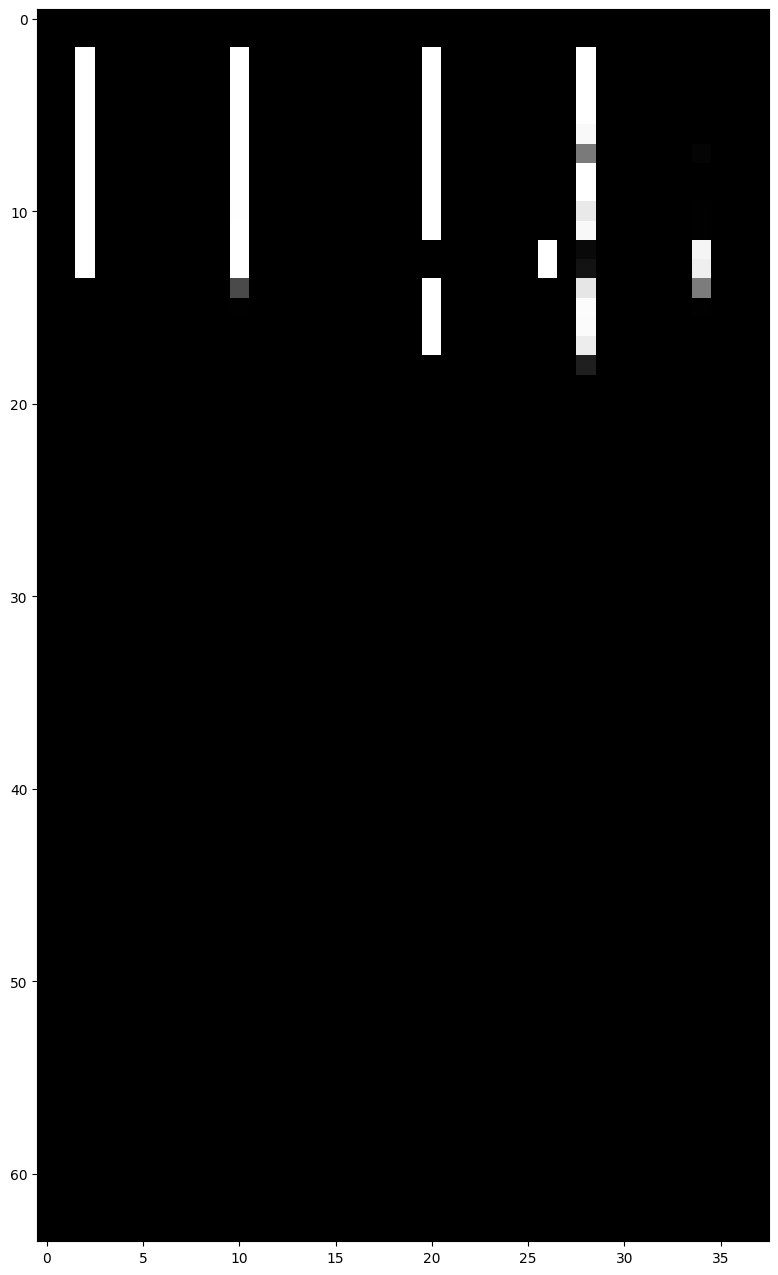

Epoch[503/1000], Step [10/145], Reconst Loss: 10.0996, KL Div: 55.5895
Epoch[503/1000], Step [20/145], Reconst Loss: 36.2056, KL Div: 59.6404
Epoch[503/1000], Step [30/145], Reconst Loss: 11.5472, KL Div: 57.7372
Epoch[503/1000], Step [40/145], Reconst Loss: 18.3720, KL Div: 54.7882
Epoch[503/1000], Step [50/145], Reconst Loss: 15.3535, KL Div: 73.7440
Epoch[503/1000], Step [60/145], Reconst Loss: 34.6048, KL Div: 82.8824
Epoch[503/1000], Step [70/145], Reconst Loss: 14.8803, KL Div: 55.4552
Epoch[503/1000], Step [80/145], Reconst Loss: 24.6767, KL Div: 56.9717
Epoch[503/1000], Step [90/145], Reconst Loss: 23.9250, KL Div: 59.9342
Epoch[503/1000], Step [100/145], Reconst Loss: 20.6108, KL Div: 55.0037
Epoch[503/1000], Step [110/145], Reconst Loss: 18.9800, KL Div: 66.2066
Epoch[503/1000], Step [120/145], Reconst Loss: 8.5511, KL Div: 56.6268
Epoch[503/1000], Step [130/145], Reconst Loss: 19.1577, KL Div: 66.0618
Epoch[503/1000], Step [140/145], Reconst Loss: 11.2910, KL Div: 56.7304
Ep

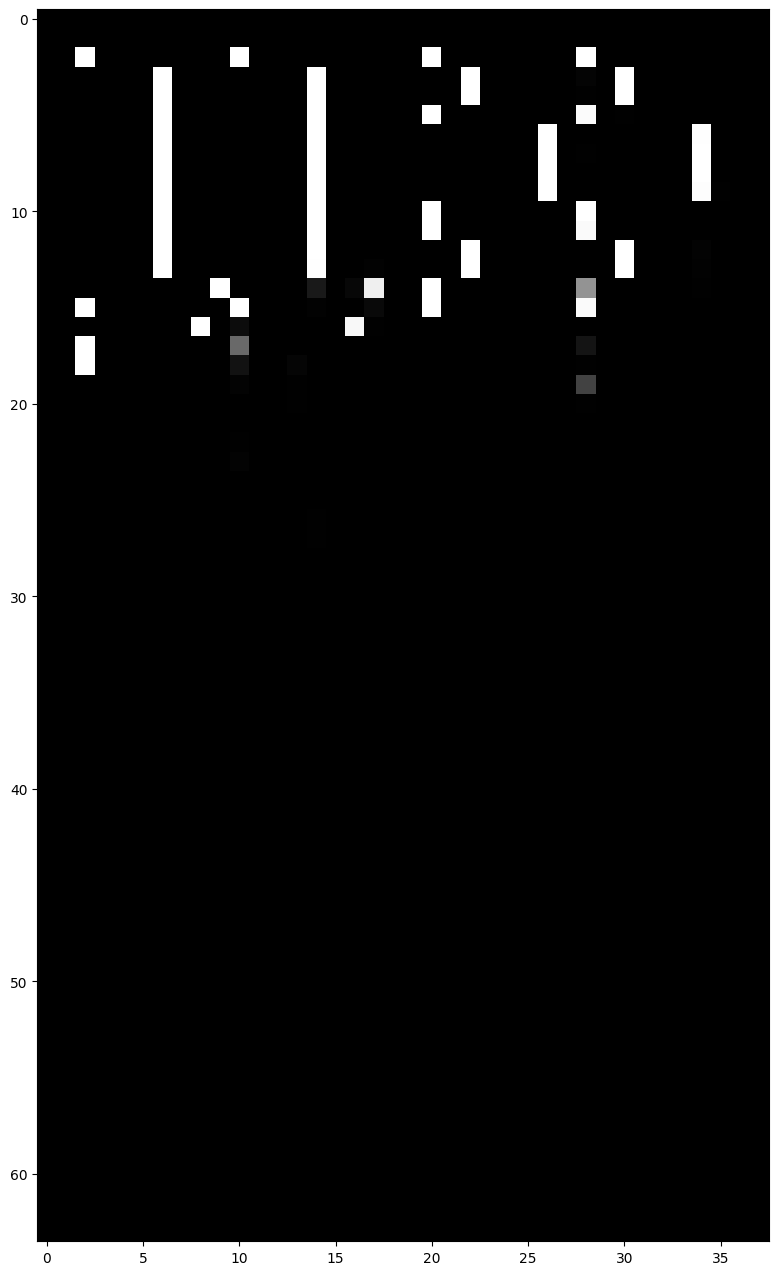

Epoch[528/1000], Step [10/145], Reconst Loss: 10.5655, KL Div: 41.8658
Epoch[528/1000], Step [20/145], Reconst Loss: 21.1811, KL Div: 68.7154
Epoch[528/1000], Step [30/145], Reconst Loss: 35.7731, KL Div: 77.3958
Epoch[528/1000], Step [40/145], Reconst Loss: 28.3467, KL Div: 70.3701
Epoch[528/1000], Step [50/145], Reconst Loss: 16.8327, KL Div: 54.2163
Epoch[528/1000], Step [60/145], Reconst Loss: 17.7803, KL Div: 48.7921
Epoch[528/1000], Step [70/145], Reconst Loss: 14.7716, KL Div: 68.8280
Epoch[528/1000], Step [80/145], Reconst Loss: 22.1988, KL Div: 60.7639
Epoch[528/1000], Step [90/145], Reconst Loss: 9.9608, KL Div: 57.3944
Epoch[528/1000], Step [100/145], Reconst Loss: 23.0704, KL Div: 73.0759
Epoch[528/1000], Step [110/145], Reconst Loss: 8.8443, KL Div: 52.5401
Epoch[528/1000], Step [120/145], Reconst Loss: 8.6490, KL Div: 55.3356
Epoch[528/1000], Step [130/145], Reconst Loss: 6.3846, KL Div: 68.8874
Epoch[528/1000], Step [140/145], Reconst Loss: 31.3620, KL Div: 70.2179
Epoch

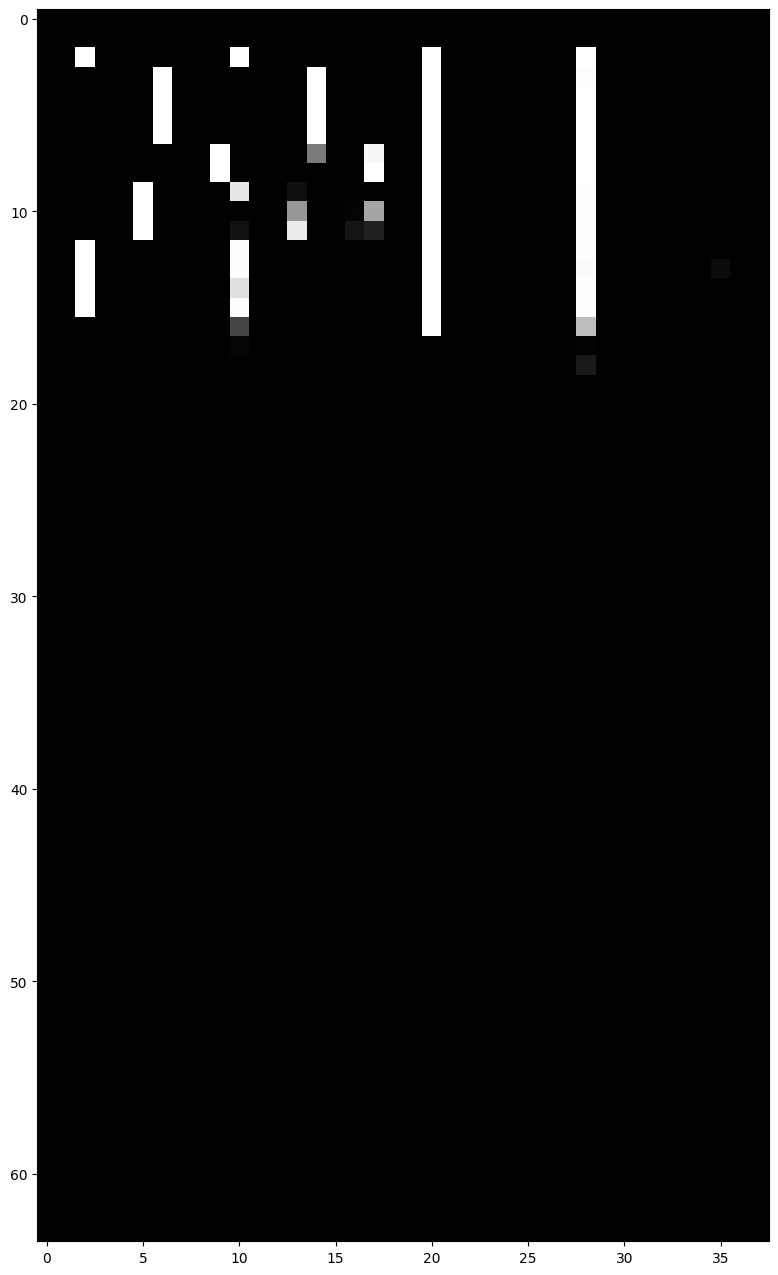

Epoch[553/1000], Step [10/145], Reconst Loss: 19.3594, KL Div: 60.6504
Epoch[553/1000], Step [20/145], Reconst Loss: 26.5219, KL Div: 62.9481
Epoch[553/1000], Step [30/145], Reconst Loss: 18.9711, KL Div: 66.2999
Epoch[553/1000], Step [40/145], Reconst Loss: 20.8774, KL Div: 54.8948
Epoch[553/1000], Step [50/145], Reconst Loss: 16.2753, KL Div: 58.3667
Epoch[553/1000], Step [60/145], Reconst Loss: 24.5820, KL Div: 67.3490
Epoch[553/1000], Step [70/145], Reconst Loss: 16.5912, KL Div: 63.7787
Epoch[553/1000], Step [80/145], Reconst Loss: 11.3236, KL Div: 79.4401
Epoch[553/1000], Step [90/145], Reconst Loss: 11.7454, KL Div: 75.6784
Epoch[553/1000], Step [100/145], Reconst Loss: 17.7640, KL Div: 78.2397
Epoch[553/1000], Step [110/145], Reconst Loss: 14.8695, KL Div: 75.1168
Epoch[553/1000], Step [120/145], Reconst Loss: 9.1755, KL Div: 65.9042
Epoch[553/1000], Step [130/145], Reconst Loss: 16.5879, KL Div: 51.2906
Epoch[553/1000], Step [140/145], Reconst Loss: 26.4818, KL Div: 76.3063
Ep

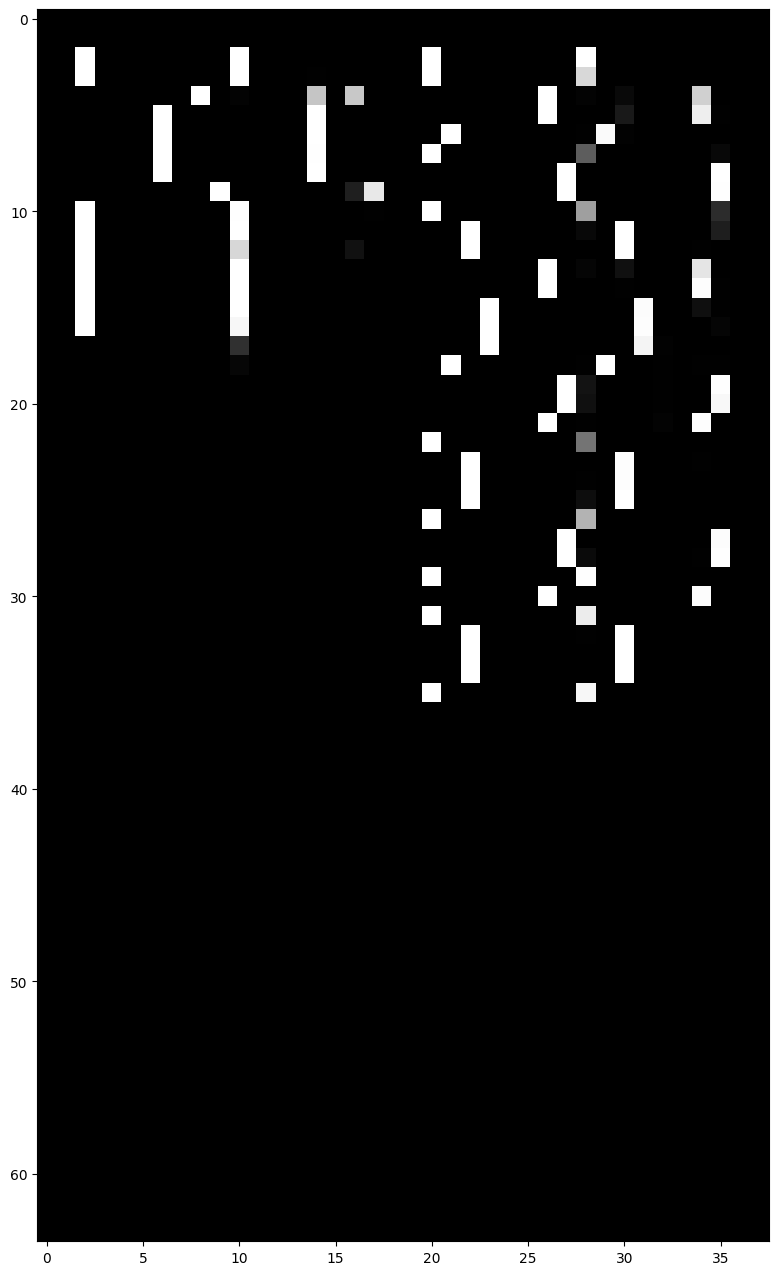

Epoch[578/1000], Step [10/145], Reconst Loss: 17.5667, KL Div: 91.6687
Epoch[578/1000], Step [20/145], Reconst Loss: 27.9650, KL Div: 63.7549
Epoch[578/1000], Step [30/145], Reconst Loss: 18.1957, KL Div: 73.5852
Epoch[578/1000], Step [40/145], Reconst Loss: 24.3164, KL Div: 71.9310
Epoch[578/1000], Step [50/145], Reconst Loss: 3.9250, KL Div: 51.4093
Epoch[578/1000], Step [60/145], Reconst Loss: 15.1846, KL Div: 61.1822
Epoch[578/1000], Step [70/145], Reconst Loss: 14.8549, KL Div: 61.1307
Epoch[578/1000], Step [80/145], Reconst Loss: 19.4533, KL Div: 84.0900
Epoch[578/1000], Step [90/145], Reconst Loss: 31.4376, KL Div: 68.6527
Epoch[578/1000], Step [100/145], Reconst Loss: 25.6154, KL Div: 63.7463
Epoch[578/1000], Step [110/145], Reconst Loss: 26.0872, KL Div: 58.2929
Epoch[578/1000], Step [120/145], Reconst Loss: 26.0036, KL Div: 60.8285
Epoch[578/1000], Step [130/145], Reconst Loss: 21.2172, KL Div: 49.8176
Epoch[578/1000], Step [140/145], Reconst Loss: 21.1261, KL Div: 83.2933
Ep

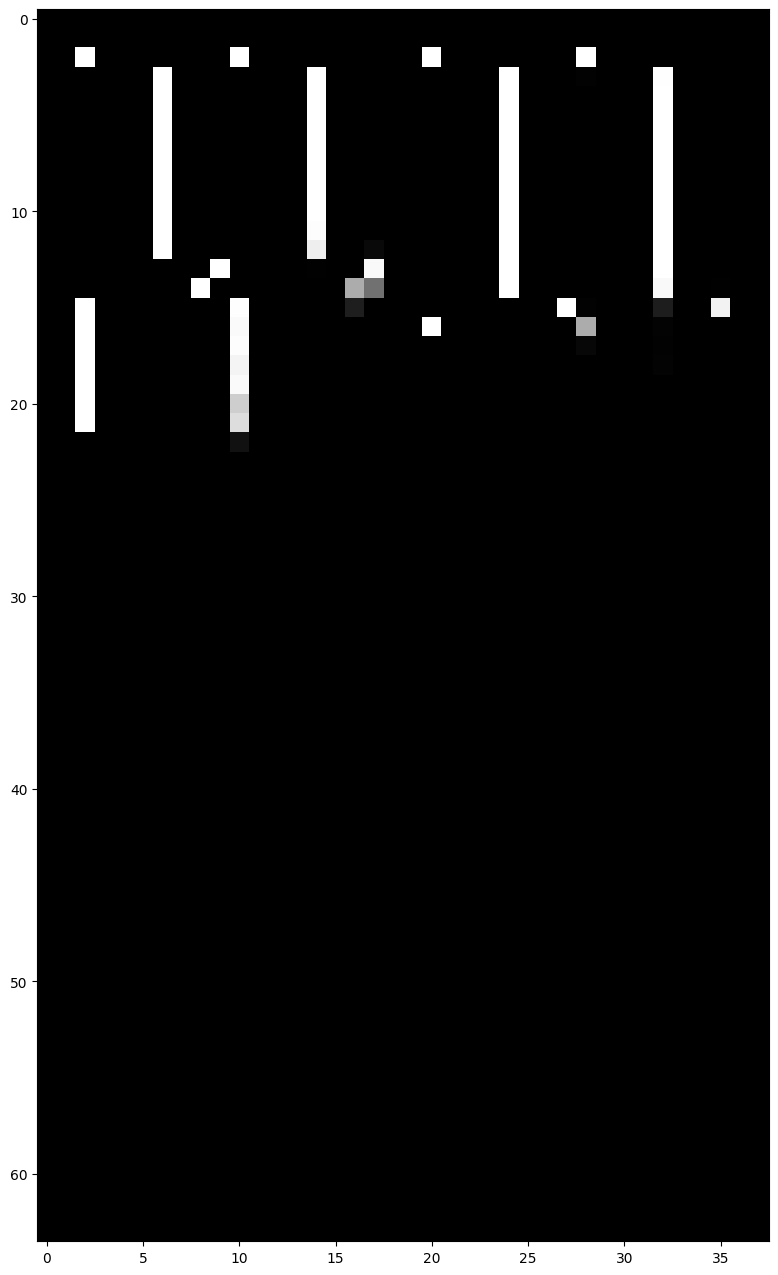

Epoch[603/1000], Step [10/145], Reconst Loss: 26.4084, KL Div: 94.2210
Epoch[603/1000], Step [20/145], Reconst Loss: 7.3309, KL Div: 61.7602
Epoch[603/1000], Step [30/145], Reconst Loss: 21.4551, KL Div: 66.2710
Epoch[603/1000], Step [40/145], Reconst Loss: 6.1348, KL Div: 45.9822
Epoch[603/1000], Step [50/145], Reconst Loss: 30.7206, KL Div: 57.4192
Epoch[603/1000], Step [60/145], Reconst Loss: 12.2465, KL Div: 60.9852
Epoch[603/1000], Step [70/145], Reconst Loss: 11.9723, KL Div: 68.0753
Epoch[603/1000], Step [80/145], Reconst Loss: 41.4757, KL Div: 60.5764
Epoch[603/1000], Step [90/145], Reconst Loss: 13.5157, KL Div: 58.5989
Epoch[603/1000], Step [100/145], Reconst Loss: 12.2538, KL Div: 63.4571
Epoch[603/1000], Step [110/145], Reconst Loss: 22.0789, KL Div: 55.8676
Epoch[603/1000], Step [120/145], Reconst Loss: 23.5637, KL Div: 60.1537
Epoch[603/1000], Step [130/145], Reconst Loss: 30.3392, KL Div: 61.9962
Epoch[603/1000], Step [140/145], Reconst Loss: 22.1045, KL Div: 64.2554
Epo

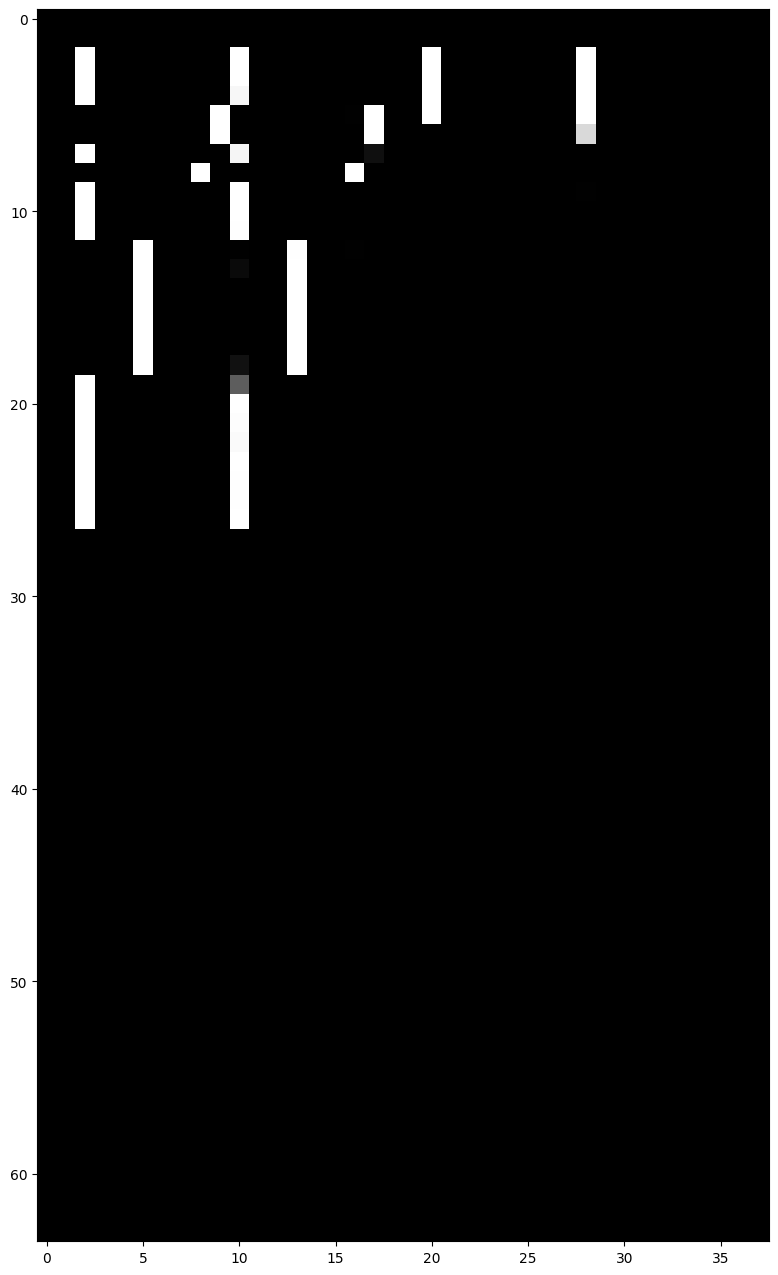

Epoch[628/1000], Step [10/145], Reconst Loss: 15.0693, KL Div: 64.1361
Epoch[628/1000], Step [20/145], Reconst Loss: 15.0406, KL Div: 55.4145
Epoch[628/1000], Step [30/145], Reconst Loss: 28.3525, KL Div: 51.1357
Epoch[628/1000], Step [40/145], Reconst Loss: 11.4896, KL Div: 73.4253
Epoch[628/1000], Step [50/145], Reconst Loss: 21.8016, KL Div: 72.6999
Epoch[628/1000], Step [60/145], Reconst Loss: 11.5569, KL Div: 81.7767
Epoch[628/1000], Step [70/145], Reconst Loss: 10.2091, KL Div: 51.4857
Epoch[628/1000], Step [80/145], Reconst Loss: 30.1416, KL Div: 54.6696
Epoch[628/1000], Step [90/145], Reconst Loss: 17.3153, KL Div: 73.5690
Epoch[628/1000], Step [100/145], Reconst Loss: 9.7261, KL Div: 68.4422
Epoch[628/1000], Step [110/145], Reconst Loss: 17.3260, KL Div: 77.9568
Epoch[628/1000], Step [120/145], Reconst Loss: 23.3624, KL Div: 63.2962
Epoch[628/1000], Step [130/145], Reconst Loss: 28.6626, KL Div: 76.9713
Epoch[628/1000], Step [140/145], Reconst Loss: 10.6844, KL Div: 59.8046
Ep

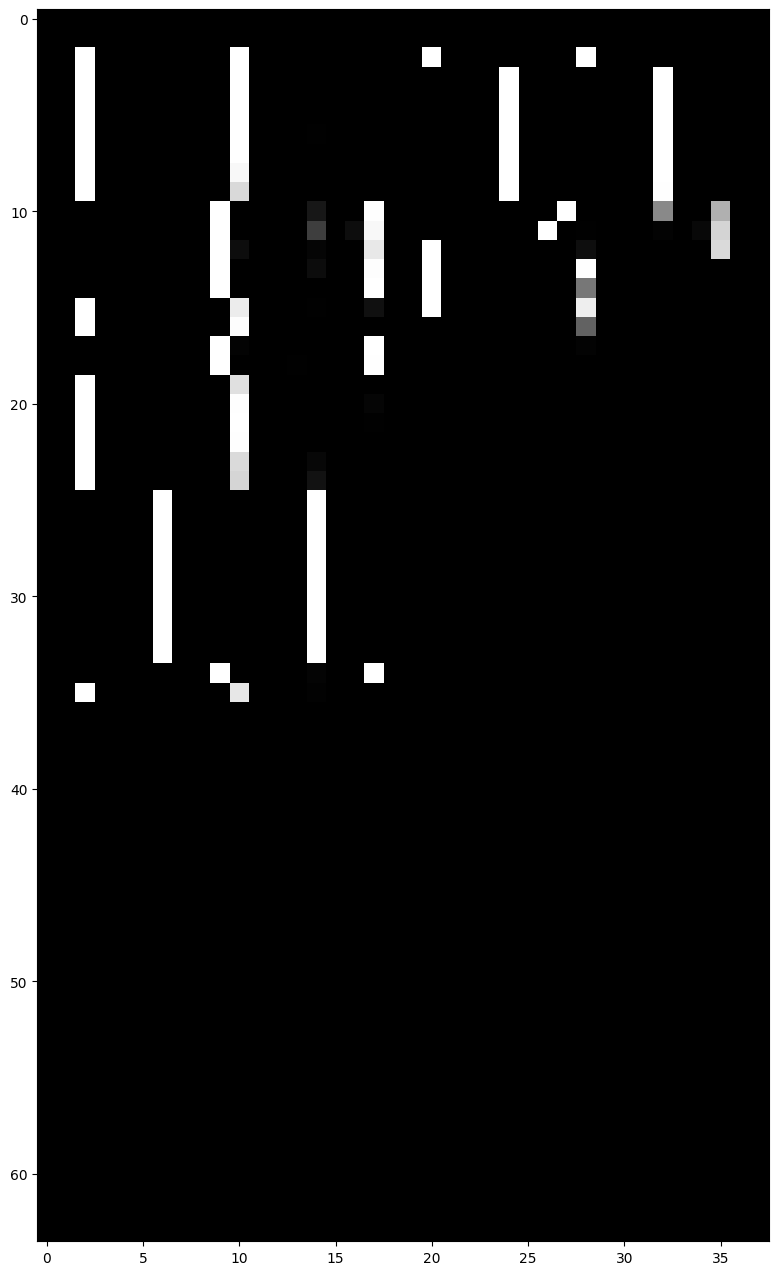

Epoch[653/1000], Step [10/145], Reconst Loss: 8.6304, KL Div: 69.2930
Epoch[653/1000], Step [20/145], Reconst Loss: 23.4692, KL Div: 66.8411
Epoch[653/1000], Step [30/145], Reconst Loss: 16.6543, KL Div: 40.8481
Epoch[653/1000], Step [40/145], Reconst Loss: 22.2871, KL Div: 53.5738
Epoch[653/1000], Step [50/145], Reconst Loss: 48.8433, KL Div: 78.7332
Epoch[653/1000], Step [60/145], Reconst Loss: 18.2867, KL Div: 64.2498
Epoch[653/1000], Step [70/145], Reconst Loss: 26.4084, KL Div: 48.0361
Epoch[653/1000], Step [80/145], Reconst Loss: 10.5822, KL Div: 82.7075
Epoch[653/1000], Step [90/145], Reconst Loss: 30.2116, KL Div: 69.7362
Epoch[653/1000], Step [100/145], Reconst Loss: 25.0536, KL Div: 61.3556
Epoch[653/1000], Step [110/145], Reconst Loss: 16.6009, KL Div: 63.2897
Epoch[653/1000], Step [120/145], Reconst Loss: 7.0146, KL Div: 88.5870
Epoch[653/1000], Step [130/145], Reconst Loss: 15.5786, KL Div: 63.9194
Epoch[653/1000], Step [140/145], Reconst Loss: 11.6751, KL Div: 65.8269
Epo

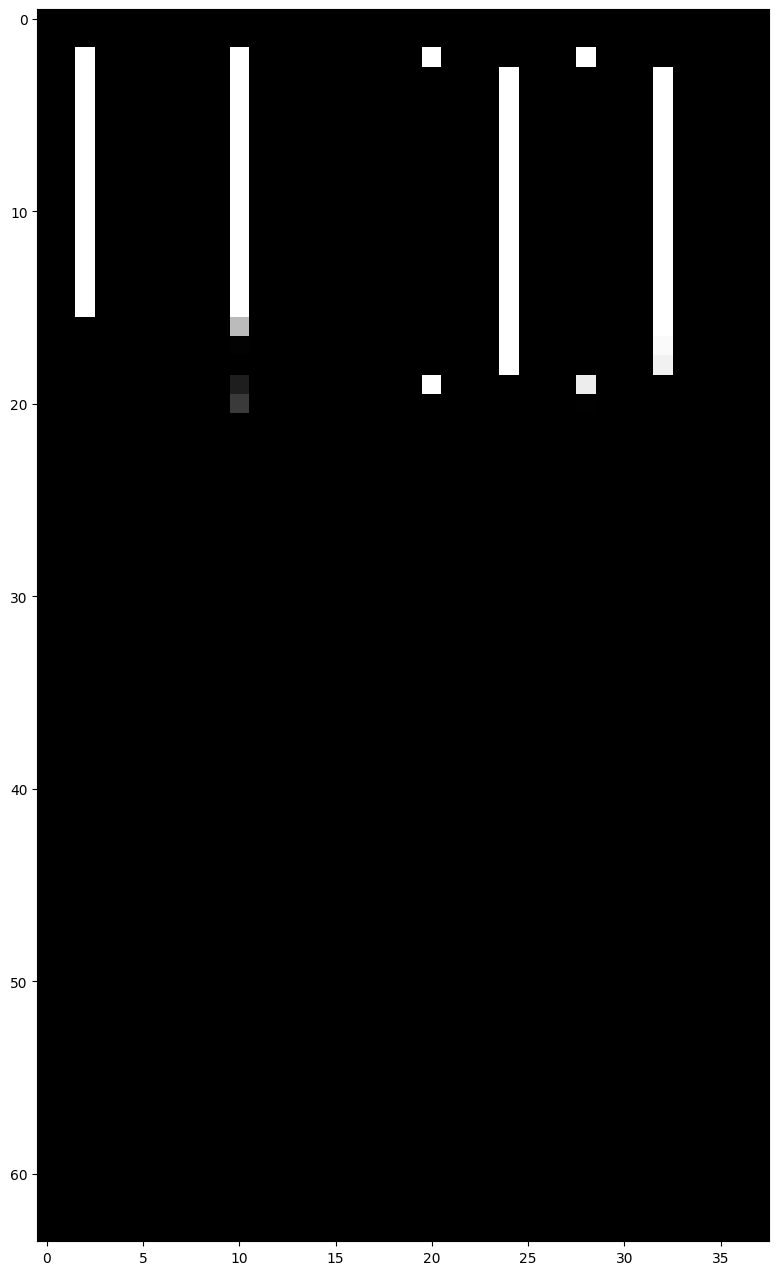

Epoch[678/1000], Step [10/145], Reconst Loss: 26.9507, KL Div: 64.0595
Epoch[678/1000], Step [20/145], Reconst Loss: 5.1973, KL Div: 53.9912
Epoch[678/1000], Step [30/145], Reconst Loss: 5.8900, KL Div: 54.2826
Epoch[678/1000], Step [40/145], Reconst Loss: 18.2936, KL Div: 55.7687
Epoch[678/1000], Step [50/145], Reconst Loss: 18.5036, KL Div: 75.2405
Epoch[678/1000], Step [60/145], Reconst Loss: 22.8406, KL Div: 71.9600
Epoch[678/1000], Step [70/145], Reconst Loss: 25.2263, KL Div: 70.8832
Epoch[678/1000], Step [80/145], Reconst Loss: 10.9958, KL Div: 55.9433
Epoch[678/1000], Step [90/145], Reconst Loss: 16.3108, KL Div: 72.9465
Epoch[678/1000], Step [100/145], Reconst Loss: 8.6491, KL Div: 63.7895
Epoch[678/1000], Step [110/145], Reconst Loss: 43.5793, KL Div: 65.2052
Epoch[678/1000], Step [120/145], Reconst Loss: 14.3369, KL Div: 65.2436
Epoch[678/1000], Step [130/145], Reconst Loss: 14.6775, KL Div: 79.6455
Epoch[678/1000], Step [140/145], Reconst Loss: 15.9615, KL Div: 66.9588
Epoc

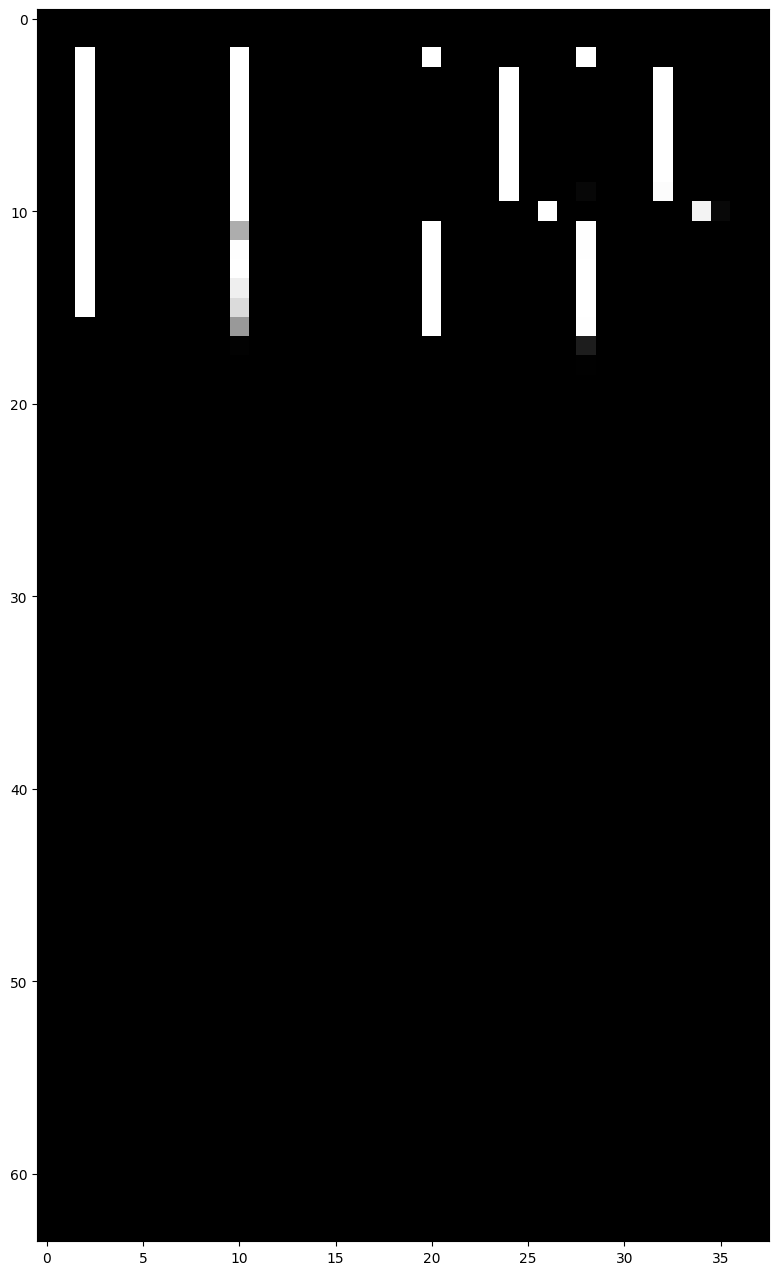

Epoch[703/1000], Step [10/145], Reconst Loss: 56.2779, KL Div: 55.2713
Epoch[703/1000], Step [20/145], Reconst Loss: 8.5880, KL Div: 74.2803
Epoch[703/1000], Step [30/145], Reconst Loss: 12.4420, KL Div: 66.4197
Epoch[703/1000], Step [40/145], Reconst Loss: 23.7030, KL Div: 73.8274
Epoch[703/1000], Step [50/145], Reconst Loss: 3.6892, KL Div: 47.2934
Epoch[703/1000], Step [60/145], Reconst Loss: 21.7393, KL Div: 66.9100
Epoch[703/1000], Step [70/145], Reconst Loss: 23.8189, KL Div: 50.6398
Epoch[703/1000], Step [80/145], Reconst Loss: 13.6260, KL Div: 76.7509
Epoch[703/1000], Step [90/145], Reconst Loss: 15.2662, KL Div: 65.5376
Epoch[703/1000], Step [100/145], Reconst Loss: 9.4726, KL Div: 73.8905
Epoch[703/1000], Step [110/145], Reconst Loss: 28.5089, KL Div: 61.2453
Epoch[703/1000], Step [120/145], Reconst Loss: 25.7987, KL Div: 59.5950
Epoch[703/1000], Step [130/145], Reconst Loss: 79.4811, KL Div: 81.3738
Epoch[703/1000], Step [140/145], Reconst Loss: 8.3375, KL Div: 64.9852
Epoch

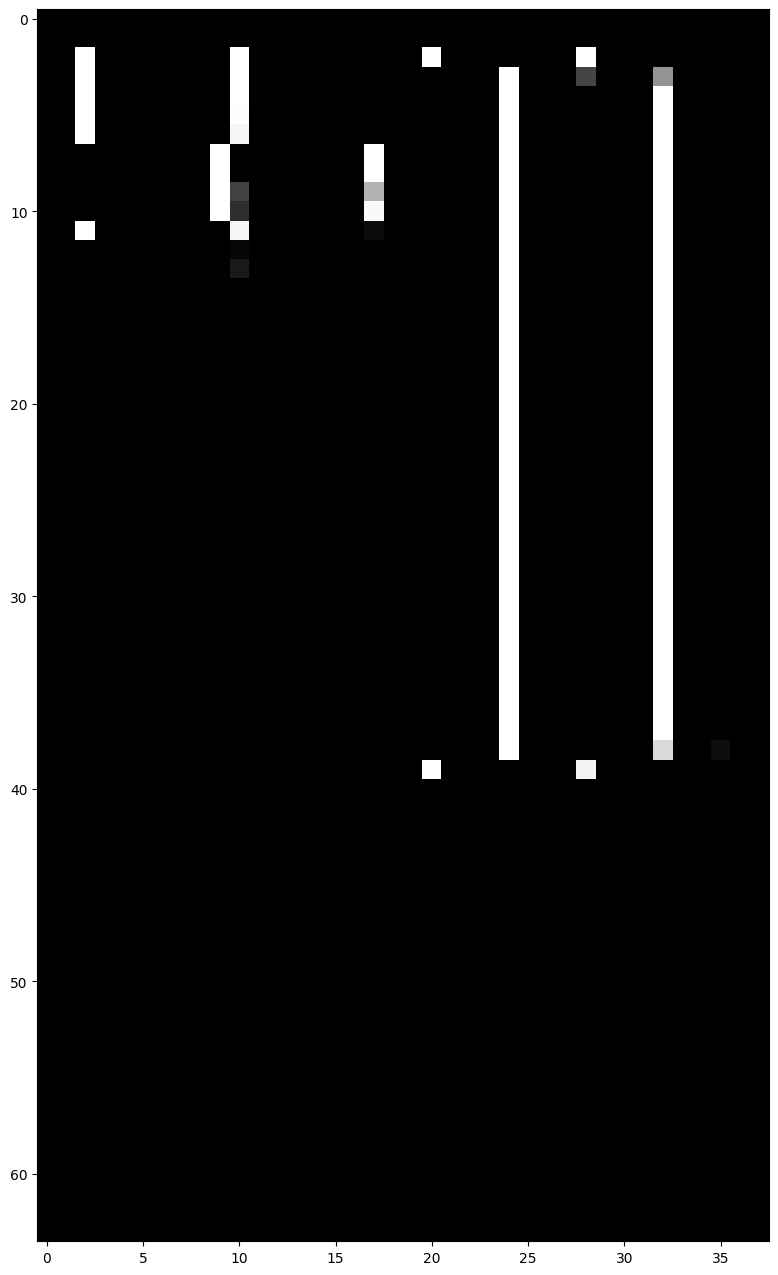

Epoch[728/1000], Step [10/145], Reconst Loss: 18.5653, KL Div: 63.8208
Epoch[728/1000], Step [20/145], Reconst Loss: 10.3987, KL Div: 55.3693
Epoch[728/1000], Step [30/145], Reconst Loss: 10.5177, KL Div: 58.8746
Epoch[728/1000], Step [40/145], Reconst Loss: 11.4440, KL Div: 68.7425
Epoch[728/1000], Step [50/145], Reconst Loss: 22.0836, KL Div: 52.8282
Epoch[728/1000], Step [60/145], Reconst Loss: 28.3678, KL Div: 54.3789
Epoch[728/1000], Step [70/145], Reconst Loss: 21.0136, KL Div: 60.6250
Epoch[728/1000], Step [80/145], Reconst Loss: 8.2197, KL Div: 53.5828
Epoch[728/1000], Step [90/145], Reconst Loss: 67.2088, KL Div: 68.0858
Epoch[728/1000], Step [100/145], Reconst Loss: 10.6277, KL Div: 58.2031
Epoch[728/1000], Step [110/145], Reconst Loss: 15.5964, KL Div: 45.3832
Epoch[728/1000], Step [120/145], Reconst Loss: 6.7427, KL Div: 76.9713
Epoch[728/1000], Step [130/145], Reconst Loss: 11.0053, KL Div: 97.9547
Epoch[728/1000], Step [140/145], Reconst Loss: 24.4411, KL Div: 53.8395
Epo

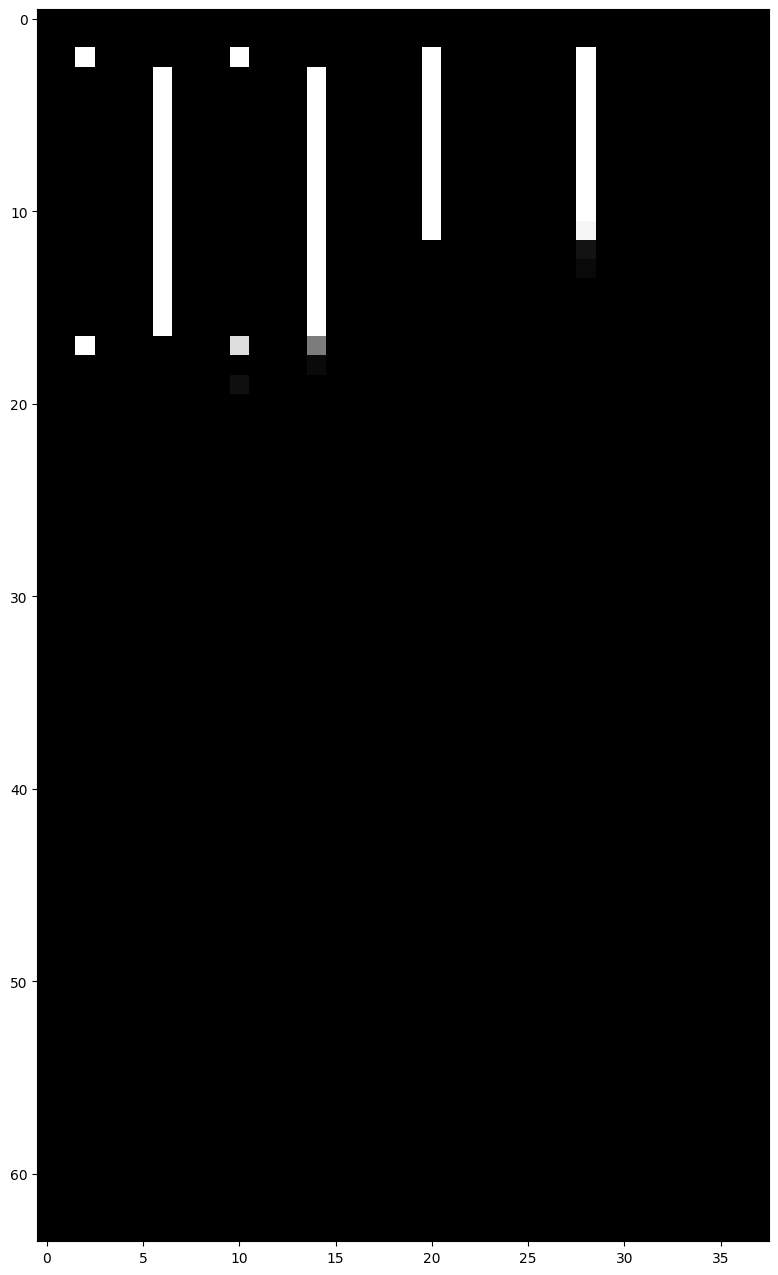

Epoch[753/1000], Step [10/145], Reconst Loss: 13.0430, KL Div: 77.4918
Epoch[753/1000], Step [20/145], Reconst Loss: 9.2590, KL Div: 56.8421
Epoch[753/1000], Step [30/145], Reconst Loss: 41.2879, KL Div: 82.8898
Epoch[753/1000], Step [40/145], Reconst Loss: 12.9258, KL Div: 61.6485
Epoch[753/1000], Step [50/145], Reconst Loss: 11.6581, KL Div: 60.8600
Epoch[753/1000], Step [60/145], Reconst Loss: 9.4735, KL Div: 77.8131
Epoch[753/1000], Step [70/145], Reconst Loss: 29.2340, KL Div: 69.1750
Epoch[753/1000], Step [80/145], Reconst Loss: 22.2032, KL Div: 74.5482
Epoch[753/1000], Step [90/145], Reconst Loss: 18.5838, KL Div: 41.4260
Epoch[753/1000], Step [100/145], Reconst Loss: 15.6356, KL Div: 74.5322
Epoch[753/1000], Step [110/145], Reconst Loss: 15.9203, KL Div: 64.7244
Epoch[753/1000], Step [120/145], Reconst Loss: 13.4786, KL Div: 64.0717
Epoch[753/1000], Step [130/145], Reconst Loss: 4.6067, KL Div: 54.5732
Epoch[753/1000], Step [140/145], Reconst Loss: 19.5086, KL Div: 62.9205
Epoc

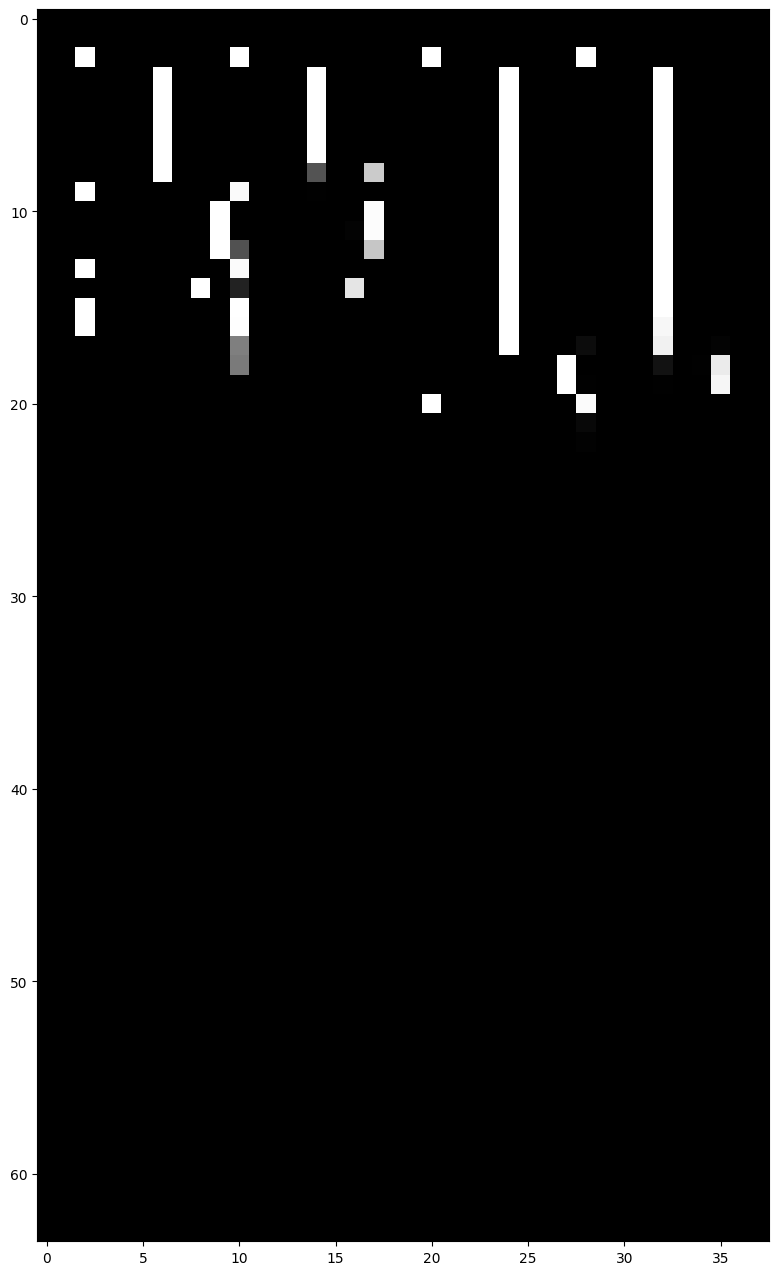

Epoch[778/1000], Step [10/145], Reconst Loss: 15.3636, KL Div: 72.4731
Epoch[778/1000], Step [20/145], Reconst Loss: 20.1497, KL Div: 73.1064
Epoch[778/1000], Step [30/145], Reconst Loss: 20.7658, KL Div: 55.9728
Epoch[778/1000], Step [40/145], Reconst Loss: 10.2075, KL Div: 79.3536
Epoch[778/1000], Step [50/145], Reconst Loss: 17.7380, KL Div: 64.2690
Epoch[778/1000], Step [60/145], Reconst Loss: 9.1453, KL Div: 77.6561
Epoch[778/1000], Step [70/145], Reconst Loss: 19.6011, KL Div: 64.0595
Epoch[778/1000], Step [80/145], Reconst Loss: 11.6490, KL Div: 60.4648
Epoch[778/1000], Step [90/145], Reconst Loss: 14.2034, KL Div: 56.2500
Epoch[778/1000], Step [100/145], Reconst Loss: 14.5700, KL Div: 42.1283
Epoch[778/1000], Step [110/145], Reconst Loss: 24.8215, KL Div: 75.9086
Epoch[778/1000], Step [120/145], Reconst Loss: 8.7822, KL Div: 59.9365
Epoch[778/1000], Step [130/145], Reconst Loss: 9.8595, KL Div: 49.2107
Epoch[778/1000], Step [140/145], Reconst Loss: 26.6852, KL Div: 67.4891
Epoc

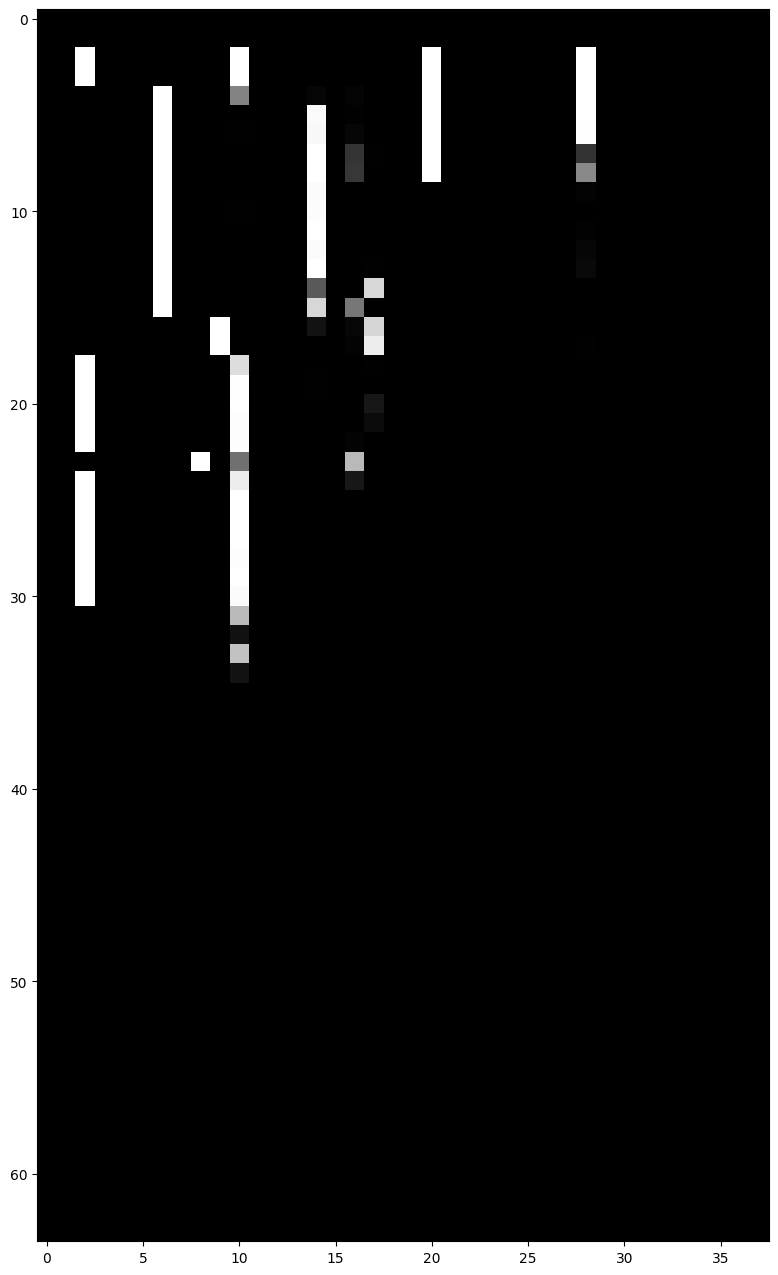

Epoch[803/1000], Step [10/145], Reconst Loss: 16.6769, KL Div: 57.4692
Epoch[803/1000], Step [20/145], Reconst Loss: 20.6624, KL Div: 58.2283
Epoch[803/1000], Step [30/145], Reconst Loss: 13.3935, KL Div: 83.7122
Epoch[803/1000], Step [40/145], Reconst Loss: 28.2641, KL Div: 73.1391
Epoch[803/1000], Step [50/145], Reconst Loss: 30.6316, KL Div: 87.0915
Epoch[803/1000], Step [60/145], Reconst Loss: 8.5388, KL Div: 64.6497
Epoch[803/1000], Step [70/145], Reconst Loss: 28.4999, KL Div: 57.9798
Epoch[803/1000], Step [80/145], Reconst Loss: 31.1705, KL Div: 64.5843
Epoch[803/1000], Step [90/145], Reconst Loss: 17.4564, KL Div: 68.7196
Epoch[803/1000], Step [100/145], Reconst Loss: 11.0982, KL Div: 55.0731
Epoch[803/1000], Step [110/145], Reconst Loss: 22.9155, KL Div: 67.6664
Epoch[803/1000], Step [120/145], Reconst Loss: 14.3172, KL Div: 70.9912
Epoch[803/1000], Step [130/145], Reconst Loss: 26.5665, KL Div: 57.5726
Epoch[803/1000], Step [140/145], Reconst Loss: 15.8883, KL Div: 70.1767
Ep

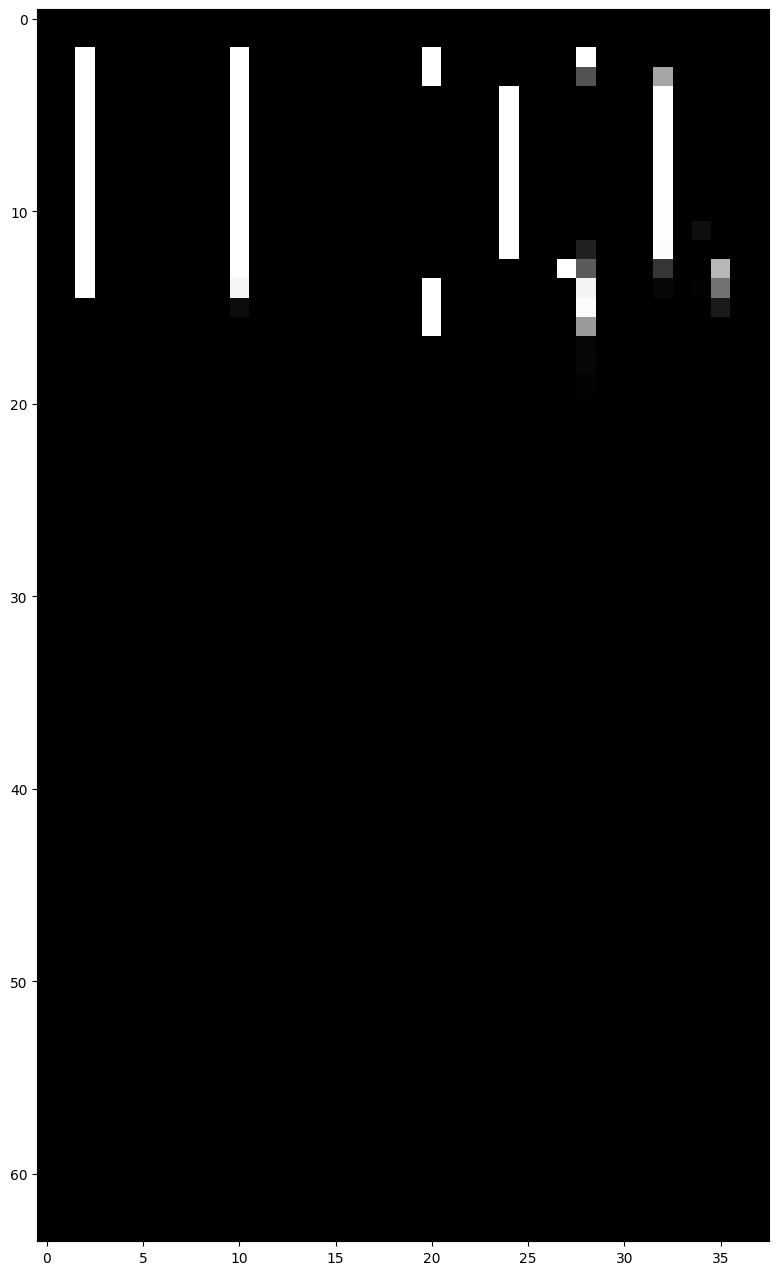

Epoch[828/1000], Step [10/145], Reconst Loss: 20.9037, KL Div: 90.4786
Epoch[828/1000], Step [20/145], Reconst Loss: 7.2292, KL Div: 69.0699
Epoch[828/1000], Step [30/145], Reconst Loss: 14.1325, KL Div: 61.6829
Epoch[828/1000], Step [40/145], Reconst Loss: 5.3283, KL Div: 46.4902
Epoch[828/1000], Step [50/145], Reconst Loss: 4.6736, KL Div: 65.9389
Epoch[828/1000], Step [60/145], Reconst Loss: 5.0734, KL Div: 56.7867
Epoch[828/1000], Step [70/145], Reconst Loss: 15.0446, KL Div: 68.4541
Epoch[828/1000], Step [80/145], Reconst Loss: 8.1911, KL Div: 91.4511
Epoch[828/1000], Step [90/145], Reconst Loss: 21.2236, KL Div: 81.9977
Epoch[828/1000], Step [100/145], Reconst Loss: 18.3034, KL Div: 45.9157
Epoch[828/1000], Step [110/145], Reconst Loss: 17.6005, KL Div: 64.8223
Epoch[828/1000], Step [120/145], Reconst Loss: 15.2403, KL Div: 65.2564
Epoch[828/1000], Step [130/145], Reconst Loss: 12.4642, KL Div: 70.0426
Epoch[828/1000], Step [140/145], Reconst Loss: 12.9869, KL Div: 54.0891
Epoch[

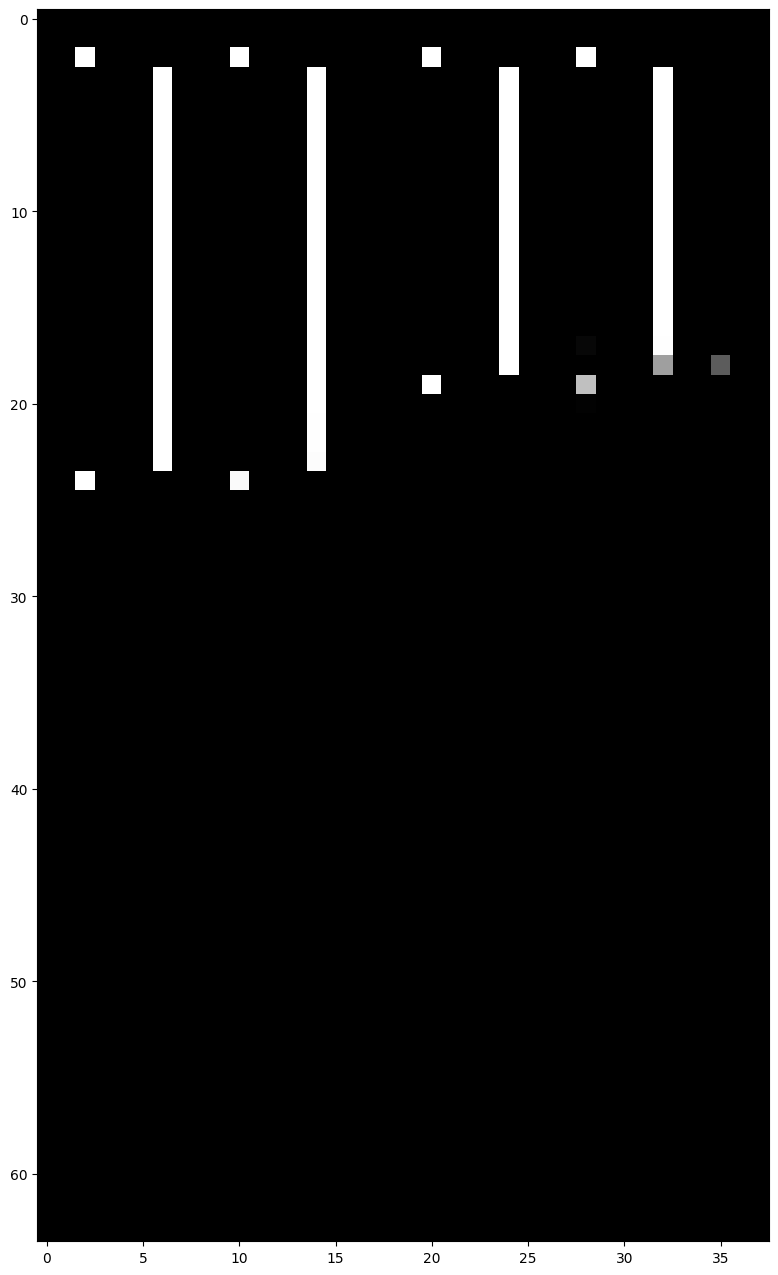

Epoch[853/1000], Step [10/145], Reconst Loss: 19.0401, KL Div: 63.1854
Epoch[853/1000], Step [20/145], Reconst Loss: 15.9675, KL Div: 78.9820
Epoch[853/1000], Step [30/145], Reconst Loss: 19.7373, KL Div: 66.8088
Epoch[853/1000], Step [40/145], Reconst Loss: 9.1663, KL Div: 67.2516
Epoch[853/1000], Step [50/145], Reconst Loss: 22.7469, KL Div: 70.9972
Epoch[853/1000], Step [60/145], Reconst Loss: 16.9341, KL Div: 70.7669
Epoch[853/1000], Step [70/145], Reconst Loss: 4.7723, KL Div: 58.5911
Epoch[853/1000], Step [80/145], Reconst Loss: 10.0853, KL Div: 52.8342
Epoch[853/1000], Step [90/145], Reconst Loss: 24.9935, KL Div: 81.0356
Epoch[853/1000], Step [100/145], Reconst Loss: 11.8834, KL Div: 78.0111
Epoch[853/1000], Step [110/145], Reconst Loss: 16.4669, KL Div: 51.4229
Epoch[853/1000], Step [120/145], Reconst Loss: 32.7689, KL Div: 67.1190
Epoch[853/1000], Step [130/145], Reconst Loss: 10.7033, KL Div: 69.8117
Epoch[853/1000], Step [140/145], Reconst Loss: 17.5085, KL Div: 51.7789
Epo

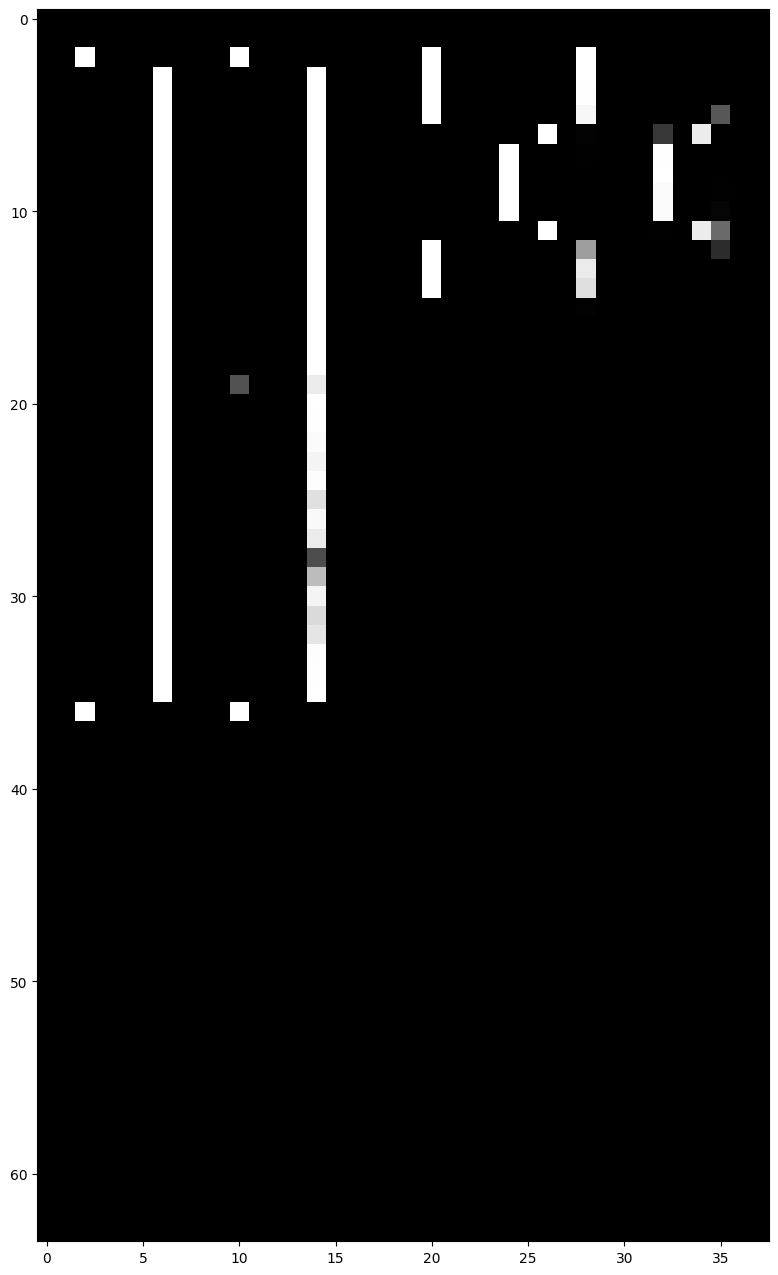

Epoch[878/1000], Step [10/145], Reconst Loss: 10.9649, KL Div: 54.6417
Epoch[878/1000], Step [20/145], Reconst Loss: 8.9337, KL Div: 51.0041
Epoch[878/1000], Step [30/145], Reconst Loss: 13.3758, KL Div: 63.5436
Epoch[878/1000], Step [40/145], Reconst Loss: 8.9861, KL Div: 78.4711
Epoch[878/1000], Step [50/145], Reconst Loss: 27.2009, KL Div: 63.4847
Epoch[878/1000], Step [60/145], Reconst Loss: 12.6825, KL Div: 65.9261
Epoch[878/1000], Step [70/145], Reconst Loss: 7.5753, KL Div: 64.1973
Epoch[878/1000], Step [80/145], Reconst Loss: 15.6080, KL Div: 81.7986
Epoch[878/1000], Step [90/145], Reconst Loss: 17.2798, KL Div: 71.4585
Epoch[878/1000], Step [100/145], Reconst Loss: 17.5091, KL Div: 55.3172
Epoch[878/1000], Step [110/145], Reconst Loss: 21.2756, KL Div: 57.1694
Epoch[878/1000], Step [120/145], Reconst Loss: 20.5587, KL Div: 62.9117
Epoch[878/1000], Step [130/145], Reconst Loss: 10.0608, KL Div: 58.4534
Epoch[878/1000], Step [140/145], Reconst Loss: 11.8051, KL Div: 58.2305
Epoc

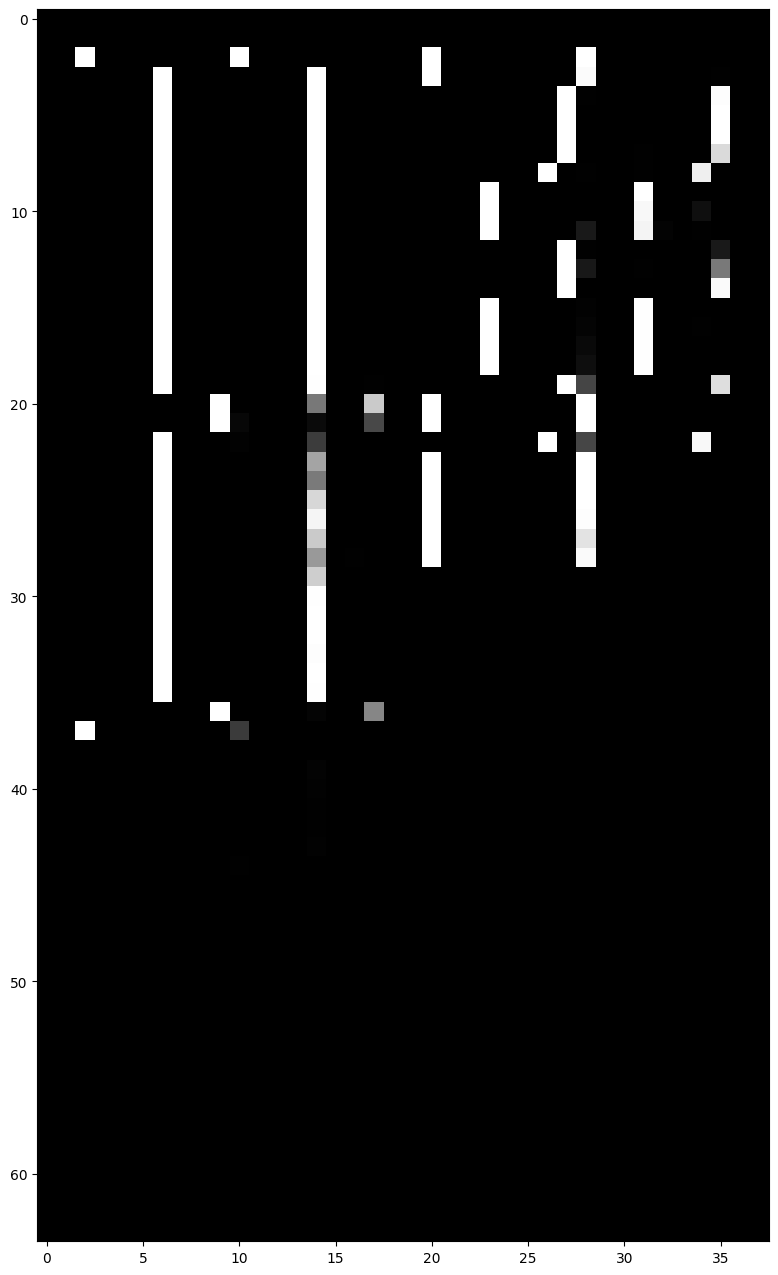

Epoch[903/1000], Step [10/145], Reconst Loss: 19.2416, KL Div: 72.5286
Epoch[903/1000], Step [20/145], Reconst Loss: 19.1606, KL Div: 64.4418
Epoch[903/1000], Step [30/145], Reconst Loss: 4.5793, KL Div: 65.7896
Epoch[903/1000], Step [40/145], Reconst Loss: 10.0429, KL Div: 53.1147
Epoch[903/1000], Step [50/145], Reconst Loss: 10.7247, KL Div: 82.7481
Epoch[903/1000], Step [60/145], Reconst Loss: 21.7001, KL Div: 51.1448
Epoch[903/1000], Step [70/145], Reconst Loss: 19.9603, KL Div: 66.0367
Epoch[903/1000], Step [80/145], Reconst Loss: 13.9621, KL Div: 40.5755
Epoch[903/1000], Step [90/145], Reconst Loss: 30.4534, KL Div: 69.0323
Epoch[903/1000], Step [100/145], Reconst Loss: 8.1418, KL Div: 62.8234
Epoch[903/1000], Step [110/145], Reconst Loss: 19.8718, KL Div: 65.1063
Epoch[903/1000], Step [120/145], Reconst Loss: 5.7985, KL Div: 49.3562
Epoch[903/1000], Step [130/145], Reconst Loss: 10.8207, KL Div: 61.3429
Epoch[903/1000], Step [140/145], Reconst Loss: 4.9459, KL Div: 65.0013
Epoch

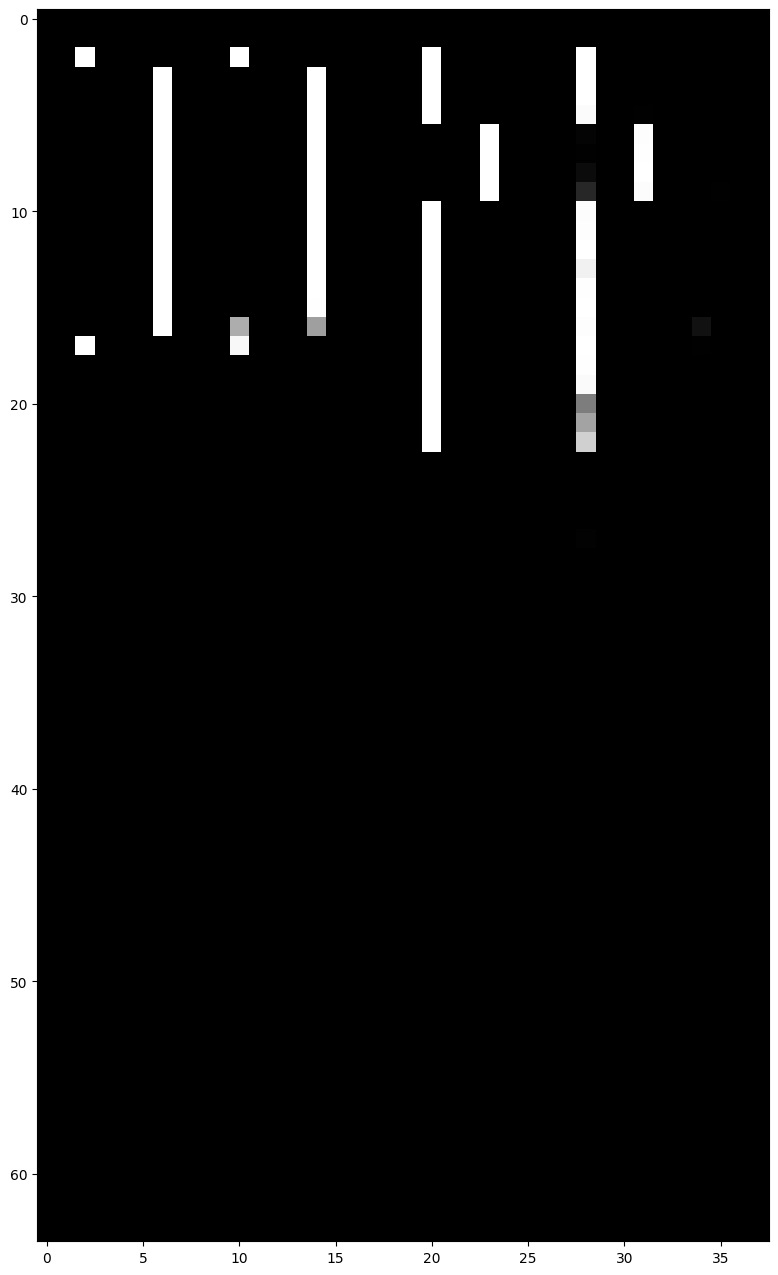

Epoch[928/1000], Step [10/145], Reconst Loss: 29.7145, KL Div: 78.9270
Epoch[928/1000], Step [20/145], Reconst Loss: 21.4939, KL Div: 66.9051
Epoch[928/1000], Step [30/145], Reconst Loss: 4.8202, KL Div: 78.4934
Epoch[928/1000], Step [40/145], Reconst Loss: 21.4422, KL Div: 65.2502
Epoch[928/1000], Step [50/145], Reconst Loss: 10.9681, KL Div: 61.8072
Epoch[928/1000], Step [60/145], Reconst Loss: 6.1587, KL Div: 55.3158
Epoch[928/1000], Step [70/145], Reconst Loss: 29.1299, KL Div: 65.3474
Epoch[928/1000], Step [80/145], Reconst Loss: 15.9385, KL Div: 79.8238
Epoch[928/1000], Step [90/145], Reconst Loss: 14.2443, KL Div: 72.5894
Epoch[928/1000], Step [100/145], Reconst Loss: 10.1817, KL Div: 58.8413
Epoch[928/1000], Step [110/145], Reconst Loss: 40.5335, KL Div: 63.5397
Epoch[928/1000], Step [120/145], Reconst Loss: 2.6960, KL Div: 63.5196
Epoch[928/1000], Step [130/145], Reconst Loss: 16.1944, KL Div: 59.6528
Epoch[928/1000], Step [140/145], Reconst Loss: 11.7411, KL Div: 57.5583
Epoc

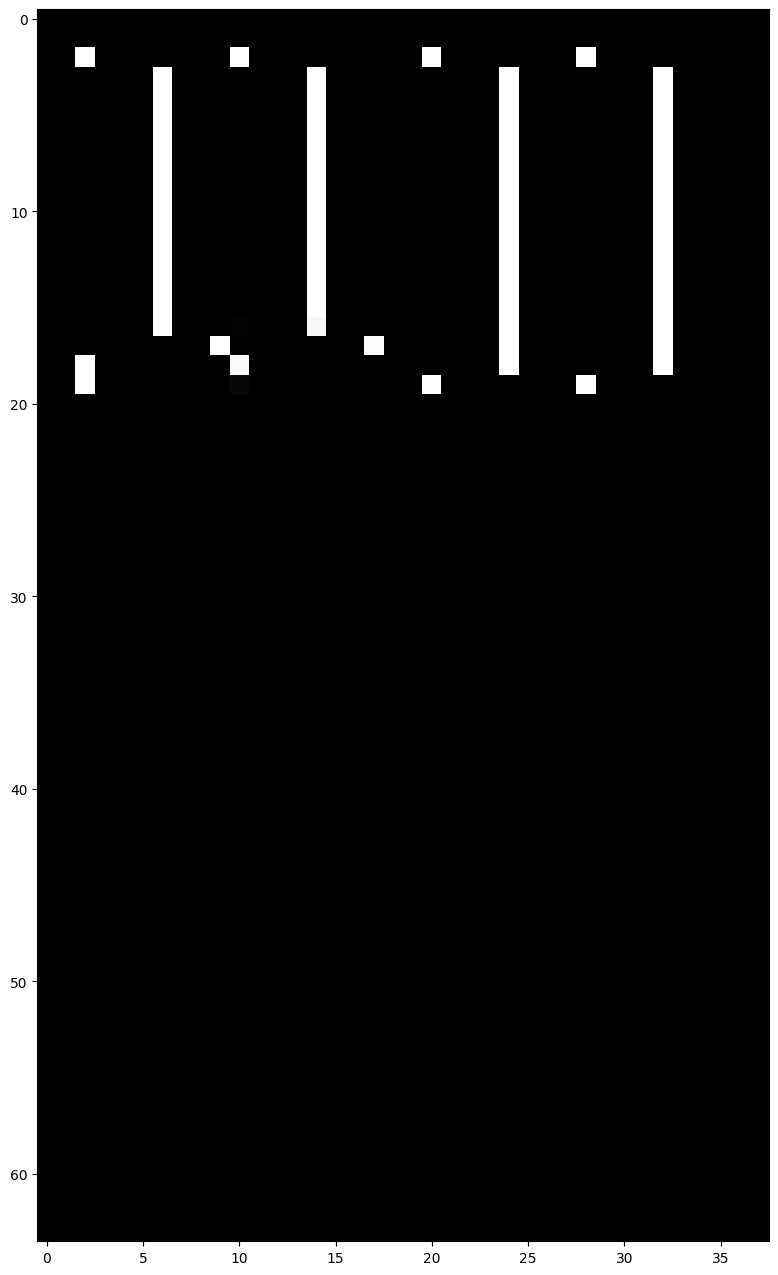

Epoch[953/1000], Step [10/145], Reconst Loss: 11.1804, KL Div: 61.1564
Epoch[953/1000], Step [20/145], Reconst Loss: 13.9456, KL Div: 76.1792
Epoch[953/1000], Step [30/145], Reconst Loss: 22.2116, KL Div: 65.5011
Epoch[953/1000], Step [40/145], Reconst Loss: 17.4626, KL Div: 81.8438
Epoch[953/1000], Step [50/145], Reconst Loss: 13.4347, KL Div: 68.5224
Epoch[953/1000], Step [60/145], Reconst Loss: 16.8328, KL Div: 70.6317
Epoch[953/1000], Step [70/145], Reconst Loss: 11.5808, KL Div: 42.6411
Epoch[953/1000], Step [80/145], Reconst Loss: 22.0371, KL Div: 58.7456
Epoch[953/1000], Step [90/145], Reconst Loss: 12.4266, KL Div: 65.2401
Epoch[953/1000], Step [100/145], Reconst Loss: 17.6502, KL Div: 46.4176
Epoch[953/1000], Step [110/145], Reconst Loss: 30.6855, KL Div: 65.0829
Epoch[953/1000], Step [120/145], Reconst Loss: 24.9282, KL Div: 55.3961
Epoch[953/1000], Step [130/145], Reconst Loss: 21.9931, KL Div: 77.6160
Epoch[953/1000], Step [140/145], Reconst Loss: 6.9253, KL Div: 70.8381
Ep

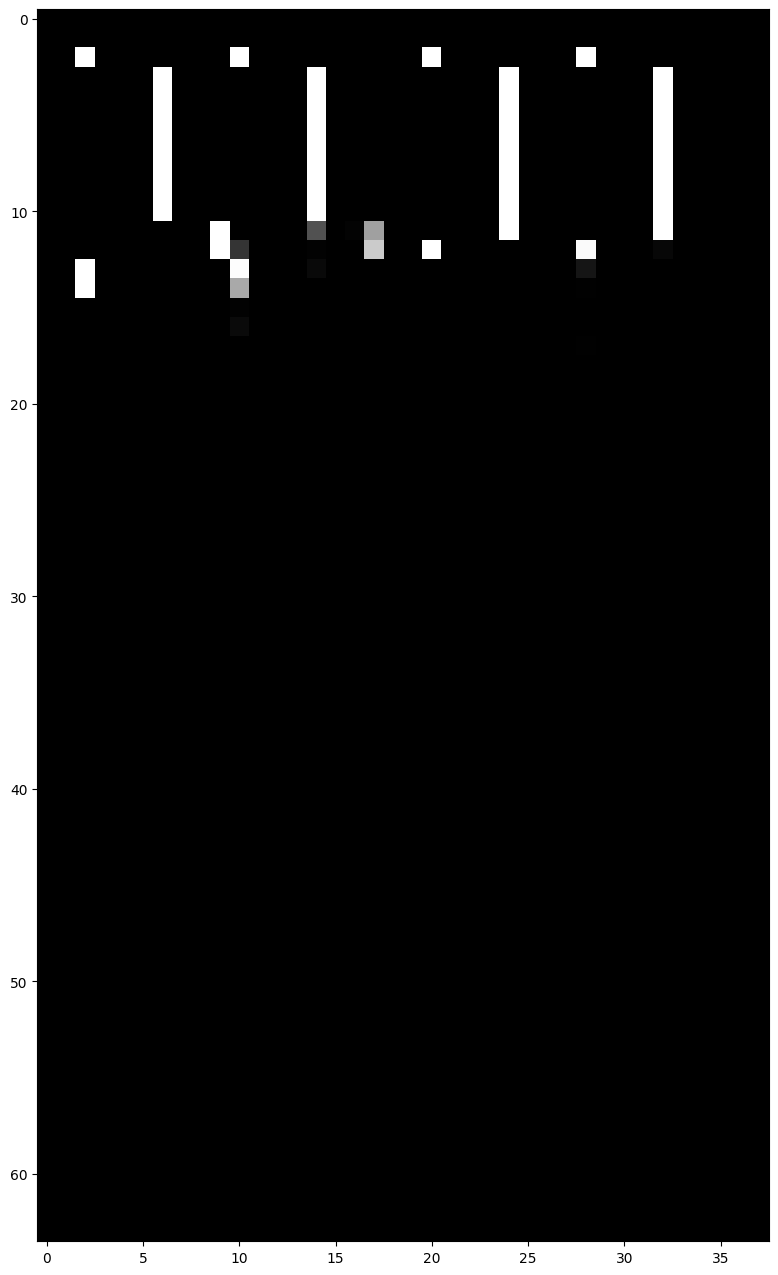

Epoch[978/1000], Step [10/145], Reconst Loss: 35.2903, KL Div: 81.9660
Epoch[978/1000], Step [20/145], Reconst Loss: 6.0301, KL Div: 50.8685
Epoch[978/1000], Step [30/145], Reconst Loss: 9.5858, KL Div: 66.4334
Epoch[978/1000], Step [40/145], Reconst Loss: 14.9867, KL Div: 40.4442
Epoch[978/1000], Step [50/145], Reconst Loss: 13.8641, KL Div: 59.3944
Epoch[978/1000], Step [60/145], Reconst Loss: 18.1297, KL Div: 57.8394
Epoch[978/1000], Step [70/145], Reconst Loss: 16.8155, KL Div: 59.0144
Epoch[978/1000], Step [80/145], Reconst Loss: 6.2795, KL Div: 68.4455
Epoch[978/1000], Step [90/145], Reconst Loss: 5.7240, KL Div: 54.5681
Epoch[978/1000], Step [100/145], Reconst Loss: 15.9422, KL Div: 71.0377
Epoch[978/1000], Step [110/145], Reconst Loss: 4.0547, KL Div: 40.8949
Epoch[978/1000], Step [120/145], Reconst Loss: 26.6260, KL Div: 48.1786
Epoch[978/1000], Step [130/145], Reconst Loss: 24.5050, KL Div: 48.5229
Epoch[978/1000], Step [140/145], Reconst Loss: 40.1741, KL Div: 71.9137
Epoch[

In [40]:
losses = []
for epoch in range(num_epochs):
    # for i, (x,_) in enumerate(data_loader):
    for i, x in enumerate(data_loader):
        x = x.view(-1, sequence_size)
        # print("x.shape after viewed:",x.shape)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        reconst_loss, kl_div = loss_function(x_reconst, x, mu, log_var)
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    losses.append(loss)     

    if (epoch - 1) % 25 == 0:
        # 利用训练的模型进行测试
        with torch.no_grad():
            # 随机生成的图像
            z = torch.randn(batch_size, z_dim)
            out = model.decode(z).view(-1, 1, 60, 8)
            print(epoch+1)
            save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # 重构的图像
            out, _, _ = model(x)
            x_concat = torch.cat([x.view(-1, 1, 60, 8), out.view(-1, 1, 60, 8)], dim=3)
            
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))
            Image = mpimg.imread('new_sec/reconst-{}.png'.format(epoch+1))
            print(Image.shape)
            plt.figure(figsize= (40,16))
            plt.imshow(Image) # 显示图片
            # plt.axis('off') # 不显示坐标轴
            plt.show()



Text(0.5, 1.0, 'Loss Curve')

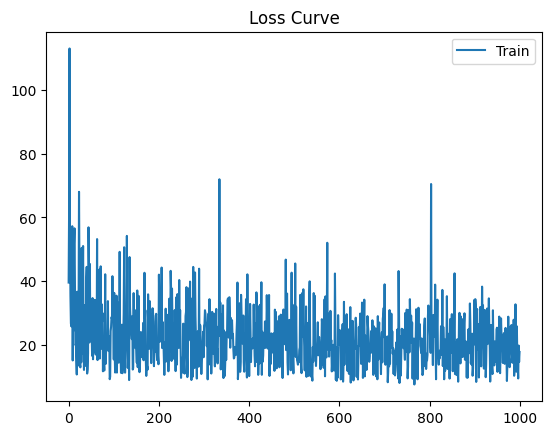

In [41]:
#VAE learn secondary structure
#VAE Learning Curv
plt.plot([loss.detach().numpy() for loss in losses], label='Train')
#plt.plot([loss.detach().numpy() for loss in test_losses], label='Test')
plt.legend()
plt.title('Loss Curve')


(64, 38, 3)


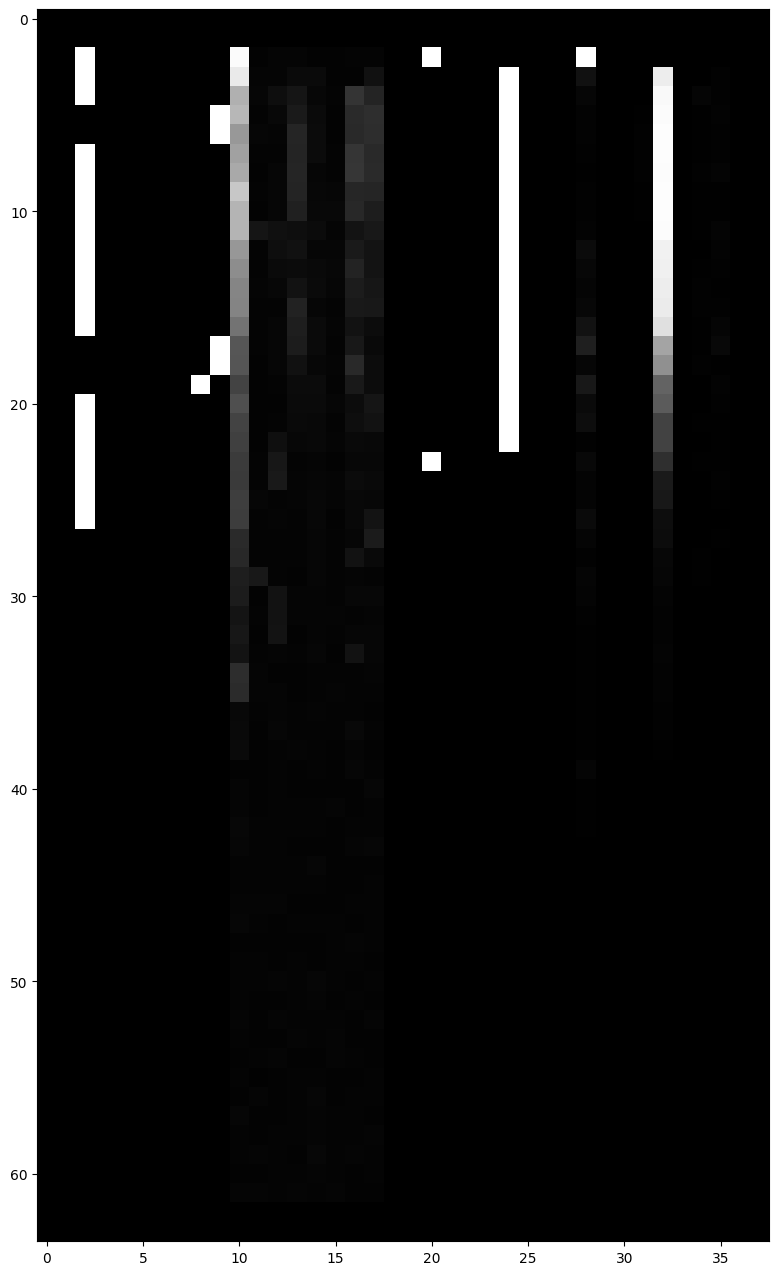

In [42]:
reconsPath = 'new_sec/reconst-2.png'
Image = mpimg.imread(reconsPath)
print(Image.shape)
plt.figure(figsize= (20,16))
plt.imshow(Image) # 显示图片
# plt.axis('off') # 不显示坐标轴
plt.show()

In [45]:
# 利用训练的模型进行测试
seqs = []
# for times in range(1000):
for i, x in enumerate(data_loader):
  with torch.no_grad():
      # 随机生成的图像
      x = x.view(-1, sequence_size)
      
      # out = model.decode(z).view(-1, 1, 30, 4)
      # seqs = []
      # for i in out:
      #   tmp = oh2seq(i.cpu(),invcharmap)
      #   seqs.append(tmp)
      # print(epoch+1)
      # save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
      # Image = mpimg.imread('samples/sampled-{}.png'.format(epoch+1))
      # print(Image.shape)
      # plt.figure(figsize= (20,16))
      # plt.imshow(Image) # 显示图片
      # # plt.axis('off') # 不显示坐标轴
      # plt.show()

    # # 重构的图像
      out, _, _ = model(x)
      out = out.view(-1, 1, 60, 8)
      for i in out:
        # print(out)
        tmp = oh2seq(i.cpu(),invcharmap)
        seqs.append(tmp)
    # x_concat = torch.cat([x.view(-1, 1, 30, 4), out.view(-1, 1, 30, 4)], dim=3)
    
    # save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))
    # Image = mpimg.imread('samples/reconst-{}.png'.format(epoch+1))
    # print(Image.shape)
    # plt.figure(figsize= (40,16))
    # plt.imshow(Image) # 显示图片
    # # plt.axis('off') # 不显示坐标轴
    # plt.show()

In [46]:
print(seqs)

[['----TT-TT----------G------B-IIIBBIIGIBEGGGISBBBBGEEI--IB--IS'], ['-HHHHHHHHHH--HH-H--HH-HHHHHHH-HHHHIGGIIESHISBBBB-EIIGTTESBBS'], ['-HHHHHHHHHHHHHHHHHHHHH-H--HHH-HHHHHHH----H------------------'], ['---TT-S---GGGGGGG--------------S-----HGG-TTGSBBBI-SGI-I-BEBG'], ['-HHHHHHHH----H--H-----BIBBBEIIBGIBGIGIBSGGSSITSB-BII-B-BS-BS'], ['-------------HH-H-------H-HEI-BH---IGIBITITSTETBSBST-B-SEGBS'], ['-HHHHHHHHHHHHHHHH----H--HHHH--H-HH-GGIBGSIIEBEEBIBIIE-TBSSBS'], ['--SSSTTHHHHHTHHHHS-S---S---------------------BTBEBE-S-IBSBGS'], ['--------------HHHHHHTTTTS------S------T--HHHHHHHHHHHHHHHHHH-'], ['--------------------TT--------------------------HHHHHHHHHHH-'], ['-HHHHHHHHHHHHHHHHHH-HHH---S-------H-H-BI-H-STBEB-BIBG-TGGSBS'], ['--------HHHHHHHHHHHHHHHHHHHHHHHHHH---H---HHHHHHHHHHHHHHHHHH-'], ['--GGGGTT-------H------TTS--HT--HHHHHH--ITHGTGETBEEBSI-TB-EES'], ['---------------GGG------T-------------BGGG-GTGBBSSTISBIEEGIS'], ['-HHHHHHHHHHHHHH-H-----HHHHHH--H-HH--------------------------'], ['-HHHHHH

In [47]:
print(len(seqs))

1154


In [48]:
with torch.no_grad():
    z = torch.randn(batch_size, z_dim)
    out = model.decode(z).view(-1, 1, 60, 8)
    out = out.view(-1, 1, 60, 8)
    for i in out:
      # print(out)
        tmp = oh2seq(i.cpu(),invcharmap)
        print(tmp)

['---T---T-TTT---------------------------------BSSSBEGG--E-E-G']
['-HHHHHHHHHHH-HH-----HHHHH--H-----BIGIIIGSGISBGEBSBIIG--T-GIS']
['--TT-T--TTSS-----------------IITGBIIBTGEBEGETIBBT-SIG-BB-SBB']
['-HHHHHHHHHHHHHHHH---H--H--HH--------------------------------']
['--HHHHHHHHHHHHHHHHTT-TS---HHHHHHHHH--------HHHHHHHHHHHHHHHH-']
['-------------GG---------T---EE-S-----BGSBGIEBBBBG-IG-BIG-GTG']
['--GGG---HHHHHHHHHHHHHH-S---HHHHHHHHHHHT--HHHHHHHHHHHHHHHHHH-']
['--------------------------BEI-BBBIGGIGBGTGISTBTSGETT-BTB-GGS']


In [56]:
torch.save(model.state_dict(), 'save889.pth')

In [51]:
#protein design by chroma
chroma = Chroma()
#design_model = GraphDesign() 
#protein = Protein("tat.pdb")
#conditioner = conditioners.SubsequenceConditioner(design_model, protein, selection="all", weight=1, renormalize_grad=True)

count = 0
d_time = 10

file_path = "./sample1/"
for i in range(d_time):
    #with torch.no_grad():
    protein = chroma.sample(
        chain_lengths=[random.randint(5, 30)], 
        langevin_factor=8,
        inverse_temperature=8,
        sde_func="langevin")
    
    protein.to(file_path + f"sample_{count}.pdb")
    count += 1


Using cached data from /var/folders/sj/_7lx83w539s03_rmy5kmptf40000gn/T/chroma_weights/90e339502ae6b372797414167ce5a632/weights.pt
Loaded from cache
Using cached data from /var/folders/sj/_7lx83w539s03_rmy5kmptf40000gn/T/chroma_weights/03a3a9af343ae74998768a2711c8b7ce/weights.pt
Loaded from cache


Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/19 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/24 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/27 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/15 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/8 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/24 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/22 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/24 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/20 [00:00<?, ?it/s]

Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/30 [00:00<?, ?it/s]

In [54]:
#protein design by chroma ss conditioner
SS = "--HHHHHHHHHHHHHHHHTT-TC---HHHHHHHHH--------HHHHHHHHHHHHHHHH-"  
SS = SS.replace("-","C")
print(SS)
proclass_model = graph_classifier.load_model("named:public")
conditioner = conditioners.ProClassConditioner("secondary_structure", SS, max_norm=None, model=proclass_model)
ss_conditioned_protein = chroma.sample(steps=500, conditioner=conditioner, chain_lengths=[len(SS)], full_output=True)
ss_conditioned_protein[0].to(file_path + f"sample_{count}.pdb")

CCHHHHHHHHHHHHHHHHTTCTCCCCHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHHC
Using cached data from /var/folders/sj/_7lx83w539s03_rmy5kmptf40000gn/T/chroma_weights/3262b44702040b1dcfccd71ebbcf451d/weights.pt
Loaded from cache


Integrating SDE:   0%|          | 0/500 [00:00<?, ?it/s]

Potts Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sequential decoding:   0%|          | 0/60 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'to'